In [2]:
#!Pip install fancyimpute

In [3]:
#Imports

import seaborn as sns
import matplotlib as plt
import pandas as pd
import missingno as msno
import numpy as np


In [24]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
%matplotlib inline

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [84]:
def plot_countplot_with_annotations(df, column, hue=None):
    sns.set(style="whitegrid")
    ax = sns.countplot(x=column, data=df, hue=hue)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom')

    plt.show()


In [26]:
df = pd.read_csv('loans_prep.csv', index_col=False)

In [27]:
# Convert obj series to categorical

def convert_object_to_categorical(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df
    
df = convert_object_to_categorical(df)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Unnamed: 0         614 non-null    int64   
 1   Gender             601 non-null    category
 2   Married            611 non-null    category
 3   Dependents         599 non-null    category
 4   Education          614 non-null    category
 5   Self_Employed      582 non-null    category
 6   ApplicantIncome    614 non-null    int64   
 7   CoapplicantIncome  614 non-null    float64 
 8   LoanAmount         592 non-null    float64 
 9   Loan_Amount_Term   600 non-null    float64 
 10  Credit_History     564 non-null    float64 
 11  Property_Area      614 non-null    category
 12  Loan_Status        614 non-null    category
dtypes: category(7), float64(4), int64(2)
memory usage: 34.0 KB


<Axes: >

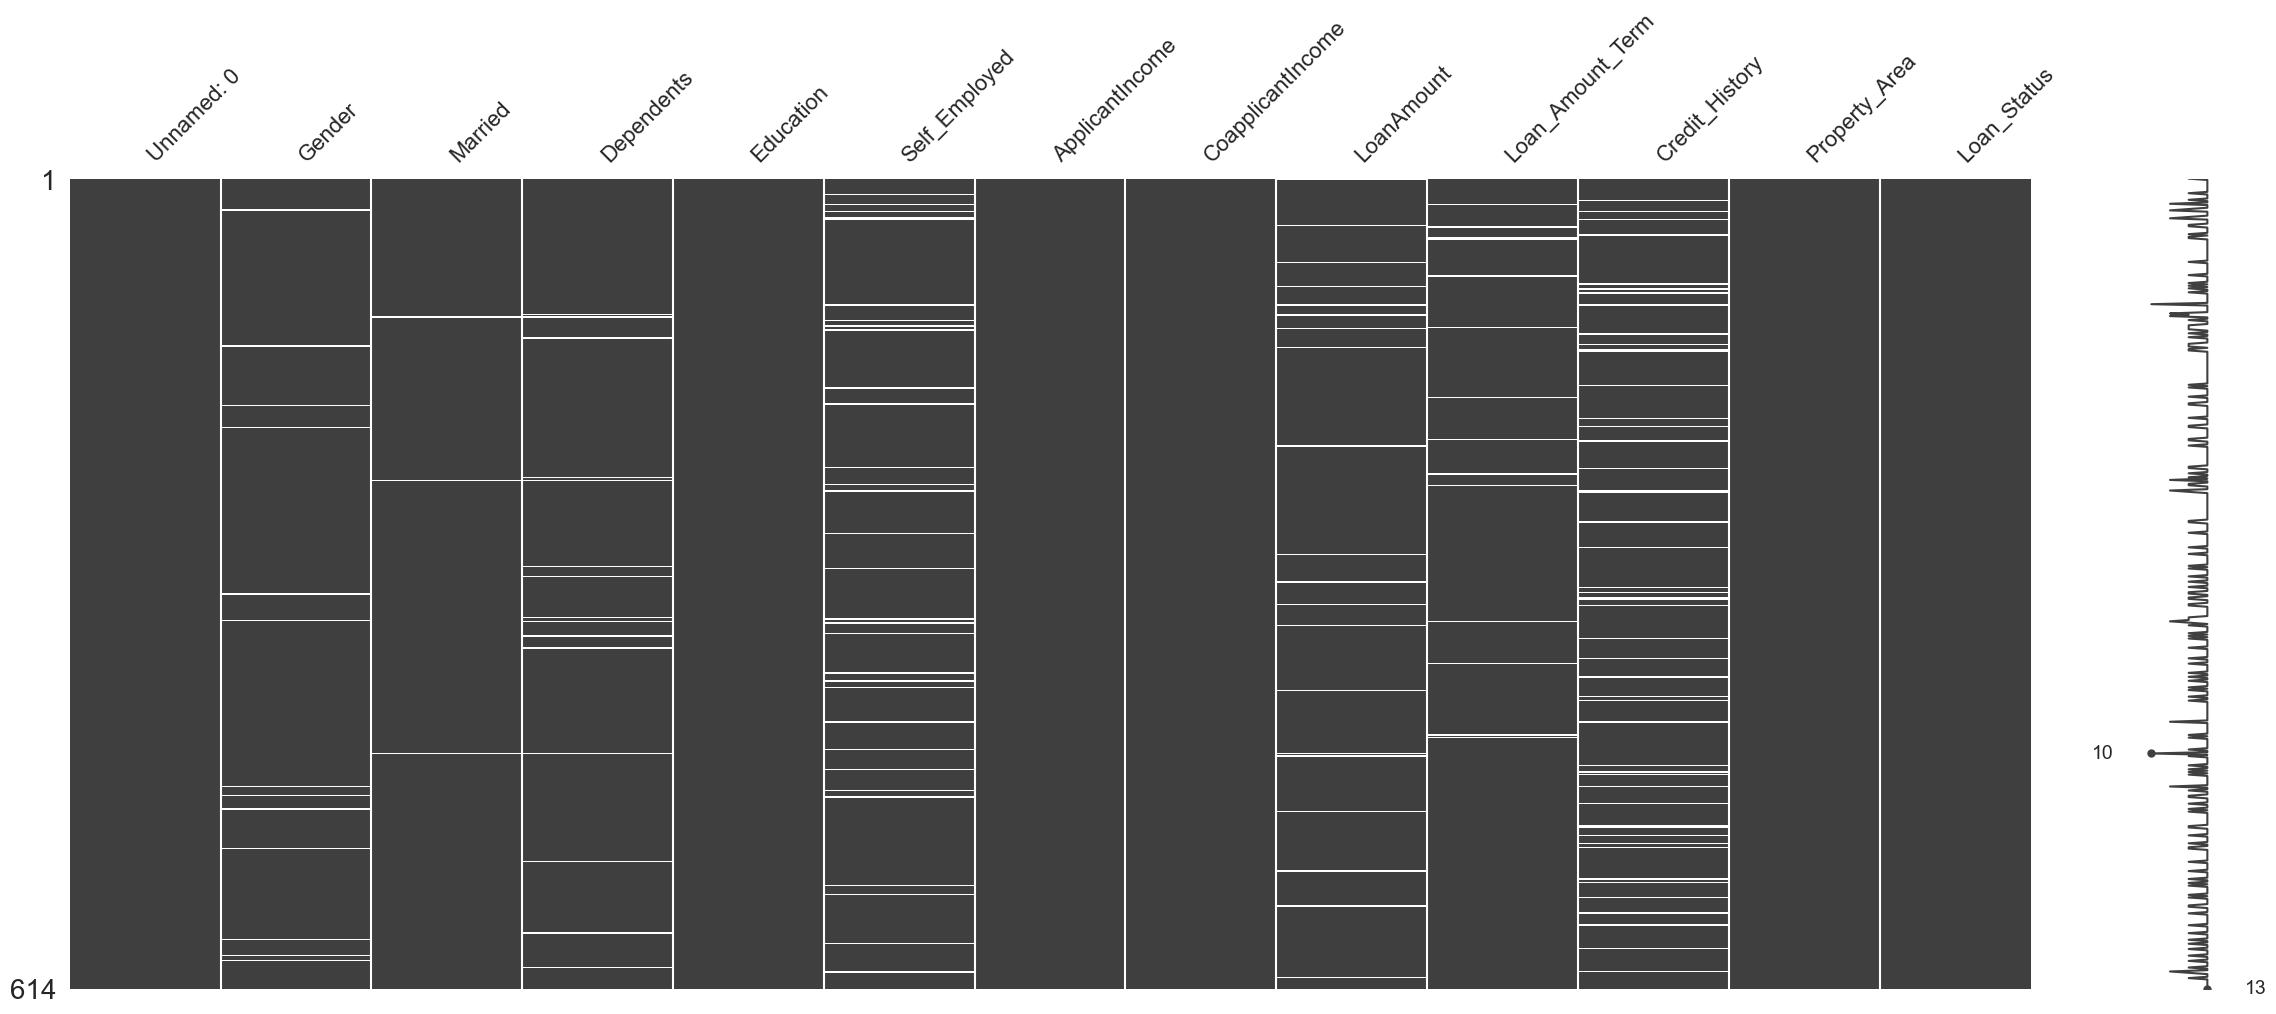

In [29]:
msno.matrix(df)

In [30]:
nan_columns = ['Gender','Married','Dependents','Self_Employed','LoanAmount','Loan_Amount_Term','Credit_History']
nan_counts = df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0] 
nan_percentage = (nan_counts / len(df)) * 100

nan_analysis = pd.DataFrame({
        'Column': nan_counts.index,
        'NaN Count': nan_counts.values,
        'NaN Percentage': nan_percentage.values})
print(nan_analysis)

        Column       NaN Count  NaN Percentage
0            Gender     13         2.117264   
1           Married      3         0.488599   
2        Dependents     15         2.442997   
3     Self_Employed     32         5.211726   
4        LoanAmount     22         3.583062   
5  Loan_Amount_Term     14         2.280130   
6    Credit_History     50         8.143322   


**** Emty values handling approach ****

Columns with empty values are split into 2 groups:
1. Personal data columns such as Gender, Married or Dependents.
2. Financial data columns, such as LoanAmount and Loan_Amount_Term.

There's no additional source of information which may help fill the empty values. 
There's also no way to conclude the missing data using an external source, as the data frame does not provide an identification of applicants or loan provider.

This way the best possible approach for taking care of  empty values is to use an imputation model such as KNN.

In [32]:
pre_fill = df['LoanAmount']

In [33]:
from fancyimpute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

columns = ['Married', 'Gender', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status','Dependents','Credit_History']

label_encoders = {}
for column in columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le
    
mice_imputer = IterativeImputer()
df_imputed = pd.DataFrame(mice_imputer.fit_transform(df[columns]), columns=columns)


In [34]:
for column in df_imputed.columns:
    df[column] = df_imputed[column]

df

Unnamed: 0  Gender  Married  Dependents  Education  Self_Employed  \
0          0       1.0     0.0        0.0        0.0          0.0        
1          1       1.0     1.0        1.0        0.0          0.0        
2          2       1.0     1.0        0.0        0.0          1.0        
3          3       1.0     1.0        0.0        1.0          0.0        
4          4       1.0     0.0        0.0        0.0          0.0        
..          ...     ...      ...         ...        ...            ...   
609      609       0.0     0.0        0.0        0.0          0.0        
610      610       1.0     1.0        3.0        0.0          0.0        
611      611       1.0     1.0        1.0        0.0          0.0        
612      612       1.0     1.0        2.0        0.0          0.0        
613      613       0.0     0.0        0.0        0.0          1.0        

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         5849                0.0             NaN          360.0        
1         4583             1508.0           128.0          360.0        
2         3000                0.0            66.0          360.0        
3         2583             2358.0           120.0          360.0        
4         6000                0.0           141.0          360.0        
..               ...                ...         ...               ...   
609       2900                0.0            71.0          360.0        
610       4106                0.0            40.0          180.0        
611       8072              240.0           253.0          360.0        
612       7583                0.0           187.0          360.0        
613       4583                0.0           133.0          360.0        

     Credit_History  Property_Area  Loan_Status  
0          1.0            2.0           1.0      
1          1.0            0.0           0.0      
2          1.0            2.0           1.0      
3          1.0            2.0           1.0      
4          1.0            2.0           1.0      
..              ...            ...          ...  
609        1.0            0.0           1.0      
610        1.0            0.0           1.0      
611        1.0            2.0           1.0      
612        1.0            2.0           1.0      
613        0.0            1.0           0.0      

[614 rows x 13 columns]

In [35]:
from sklearn.impute import KNNImputer

imp_cols = ['LoanAmount', 'Loan_Amount_Term']
knn_imputer = KNNImputer(n_neighbors=1)
imputed_data = pd.DataFrame(knn_imputer.fit_transform(df[imp_cols]),columns = imp_cols)

for col in imp_cols:
    df[col] = imputed_data[col]

In [36]:
post_fill = df['LoanAmount']

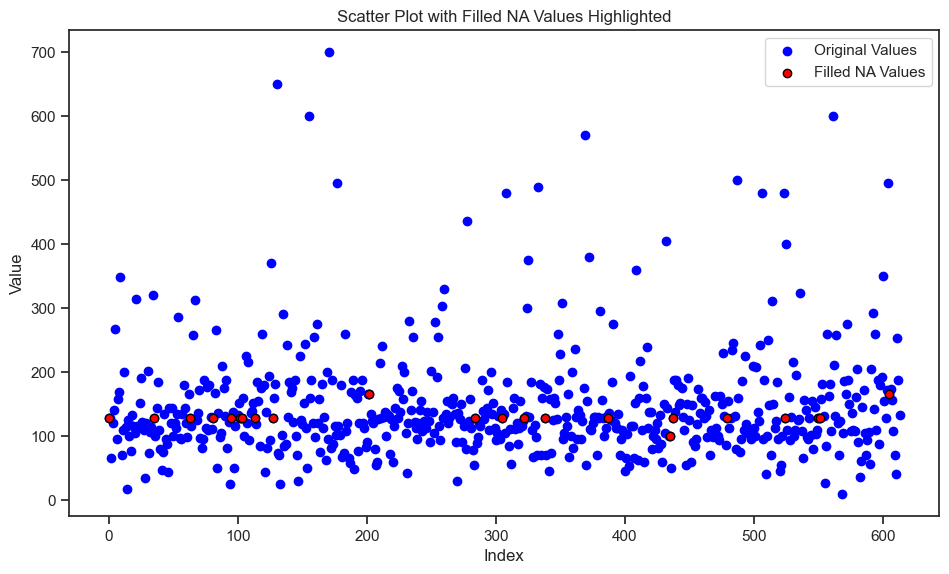

In [37]:
import matplotlib.pyplot as plt

orig_array = np.array(pre_fill)
filled_array = np.array(post_fill)

na_indices = np.where(np.isnan(orig_array))[0]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(filled_array)), filled_array, label='Original Values', color='blue')
plt.scatter(na_indices, filled_array[na_indices], label='Filled NA Values', color='red', marker='o', edgecolors='black')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot with Filled NA Values Highlighted')
plt.legend()

plt.show()

<Axes: >

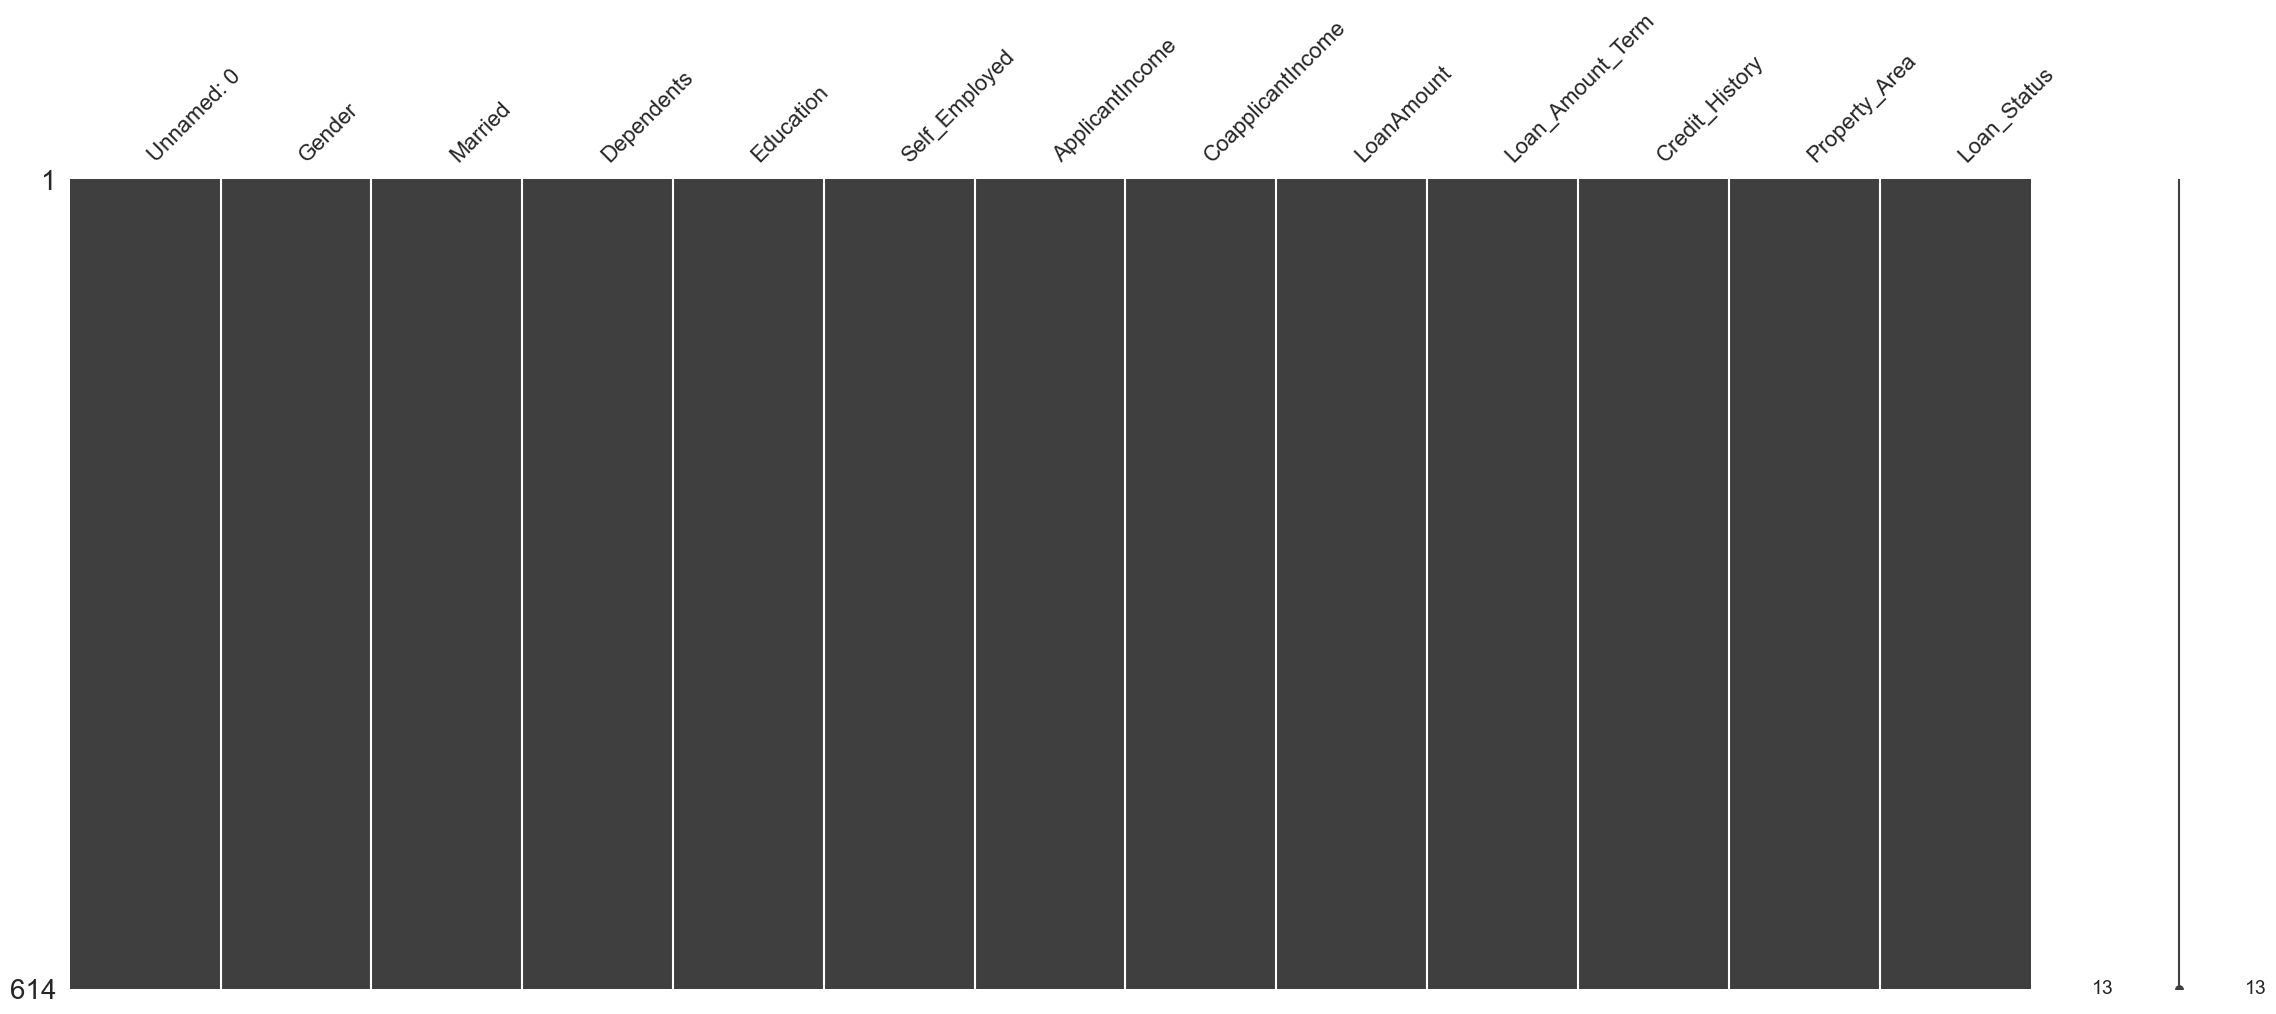

In [38]:
msno.matrix(df)

**** Outliers ****

Shape of your Data Set loaded: (614, 13)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  9
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  2
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    13 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['Unnamed: 0']
To fix these data quality issues in the dataset, impor

Number of All Scatter Plots = 45


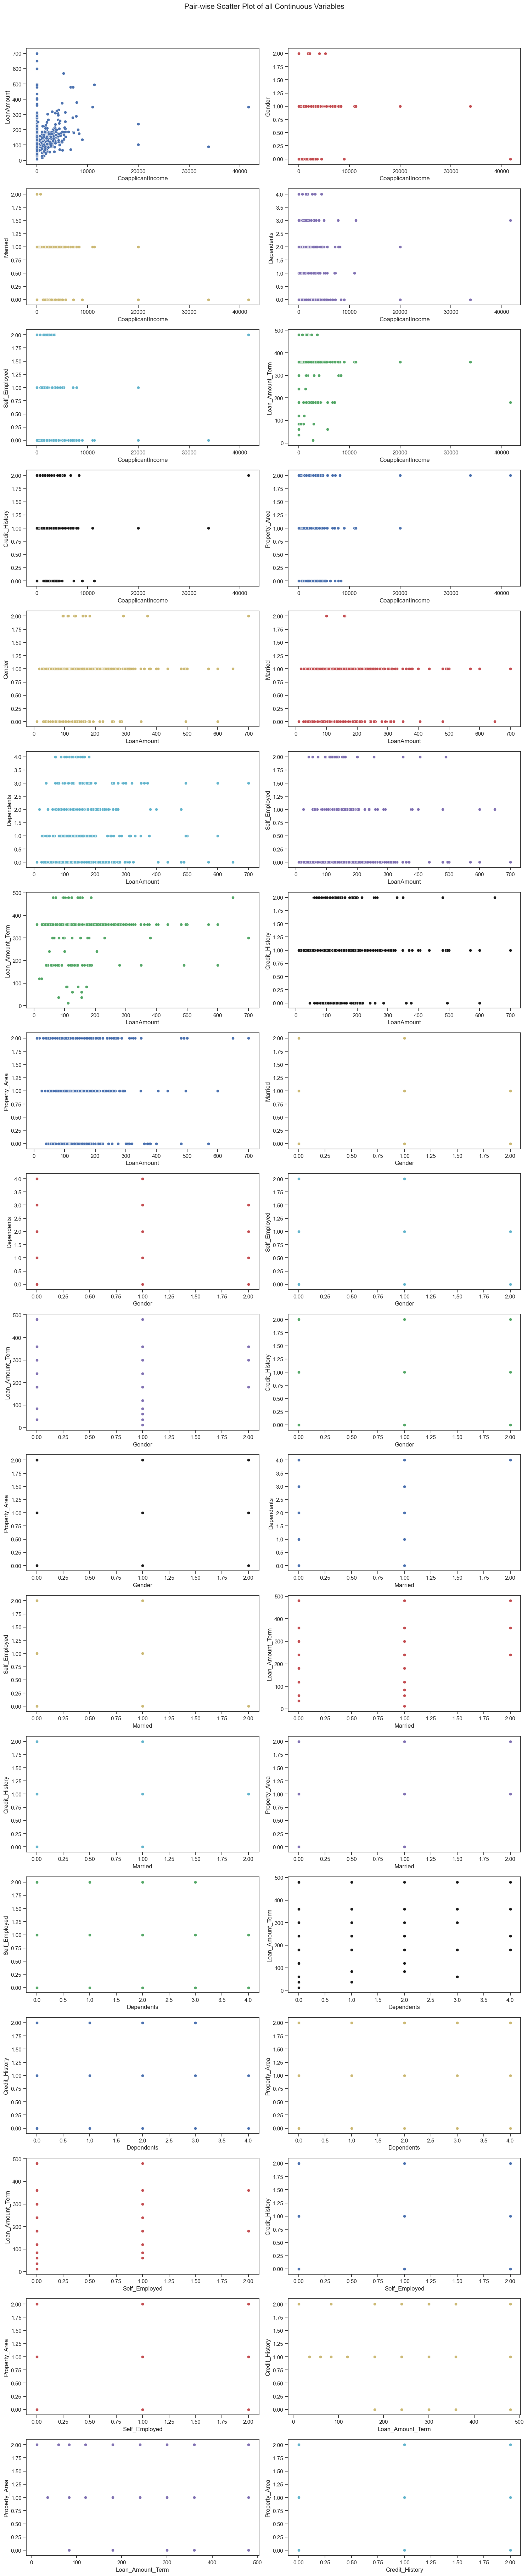

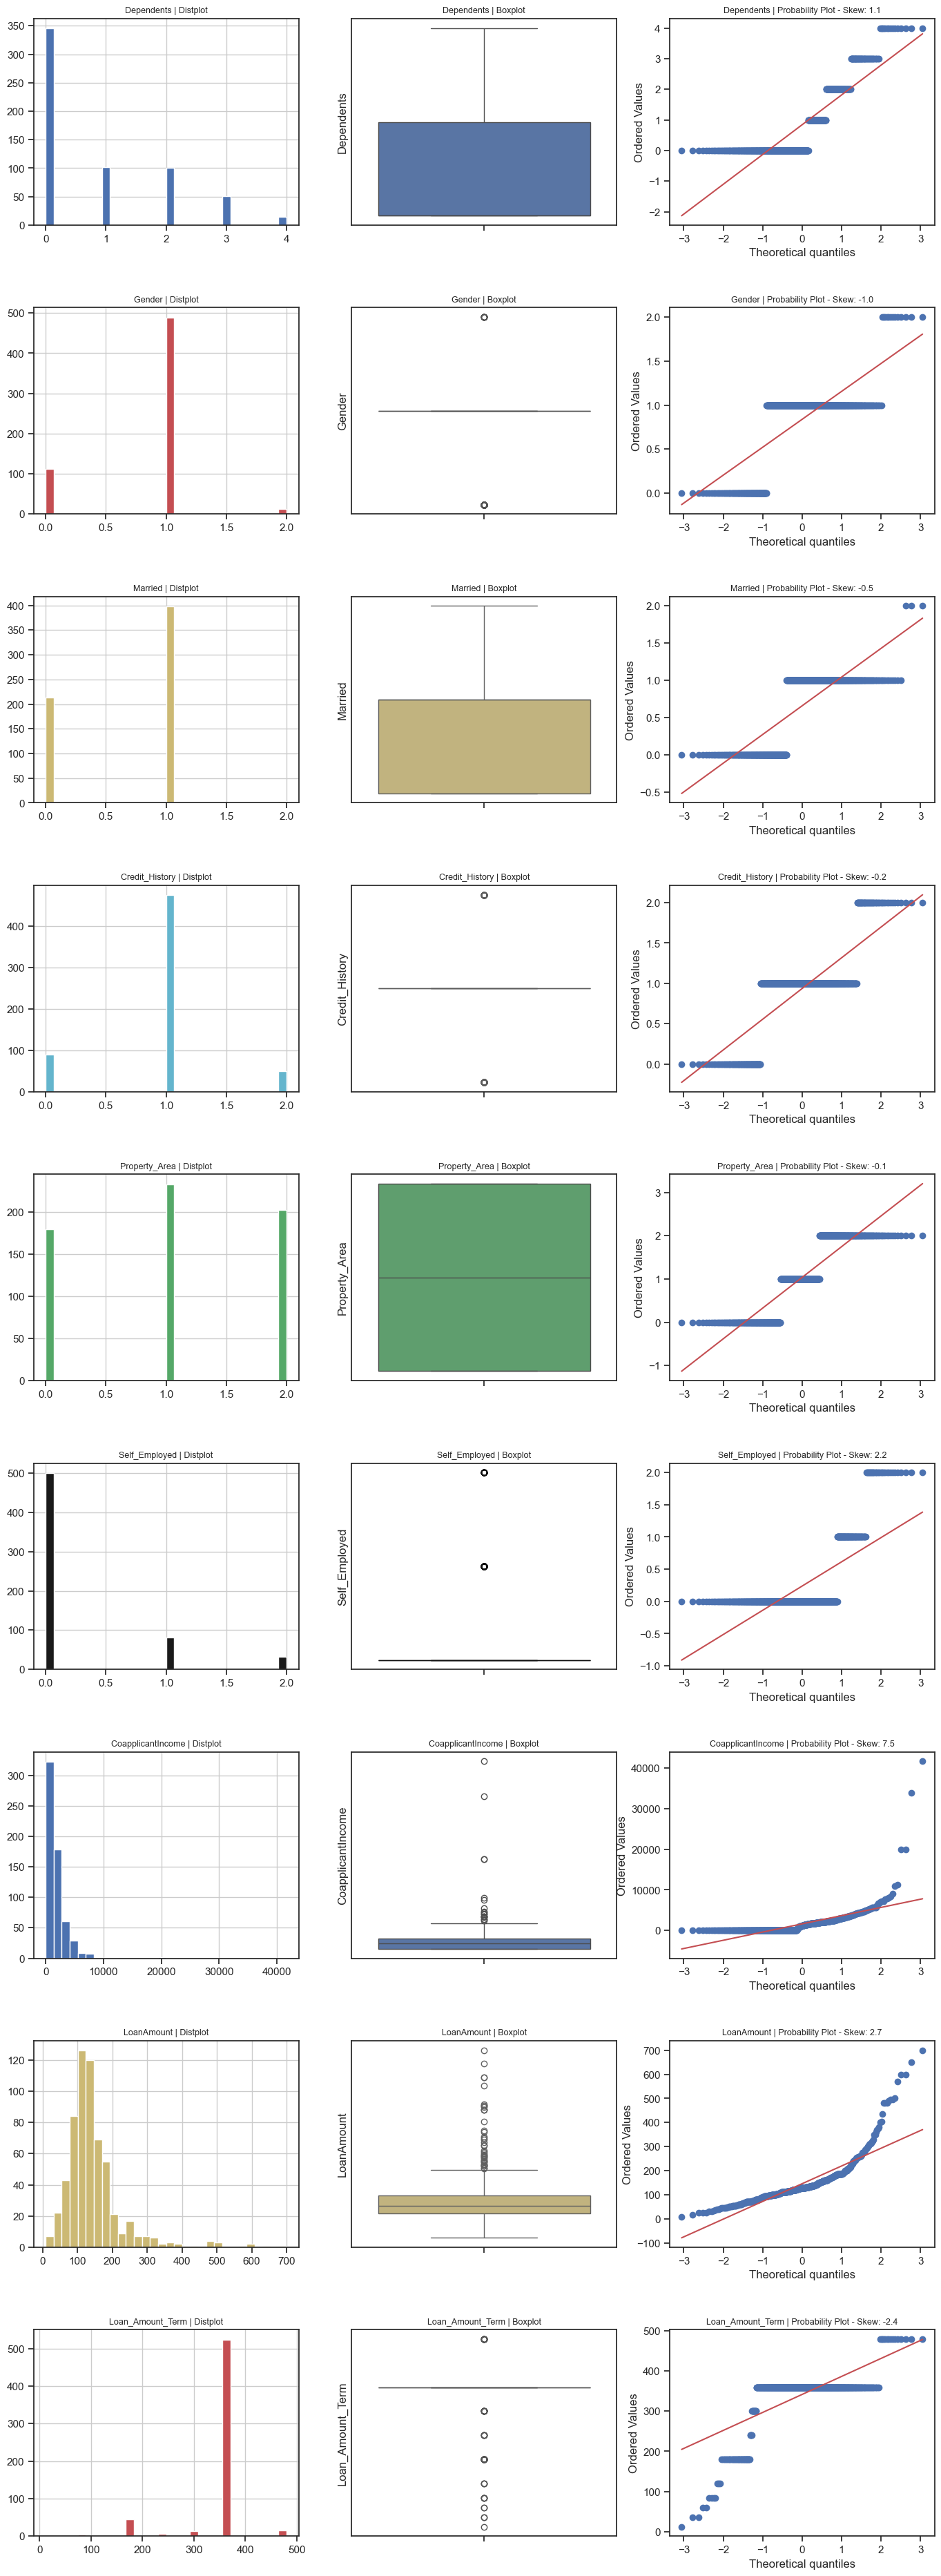

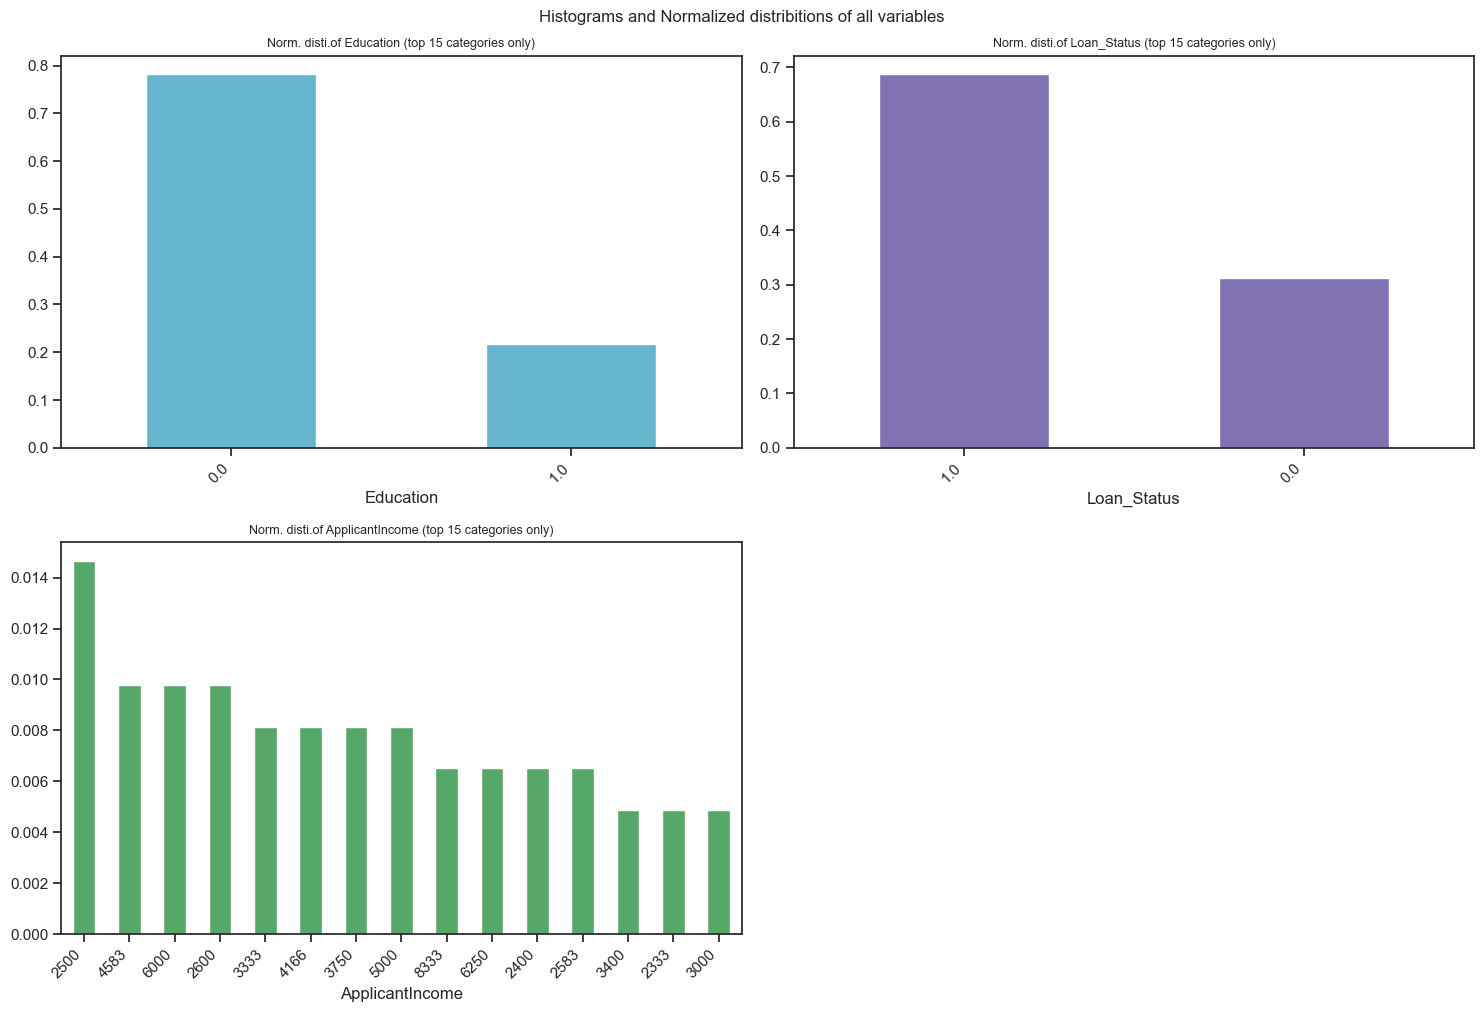

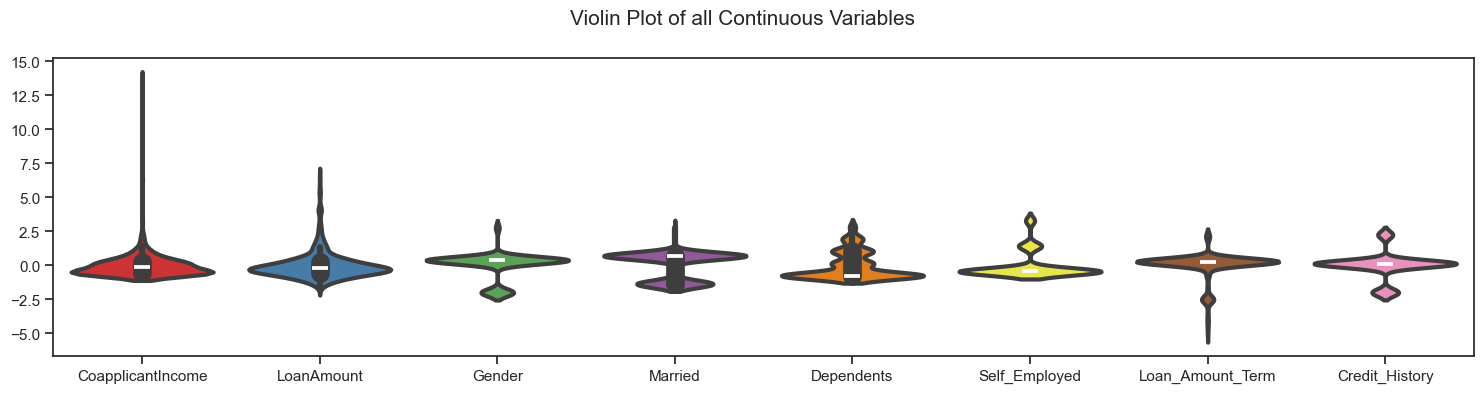

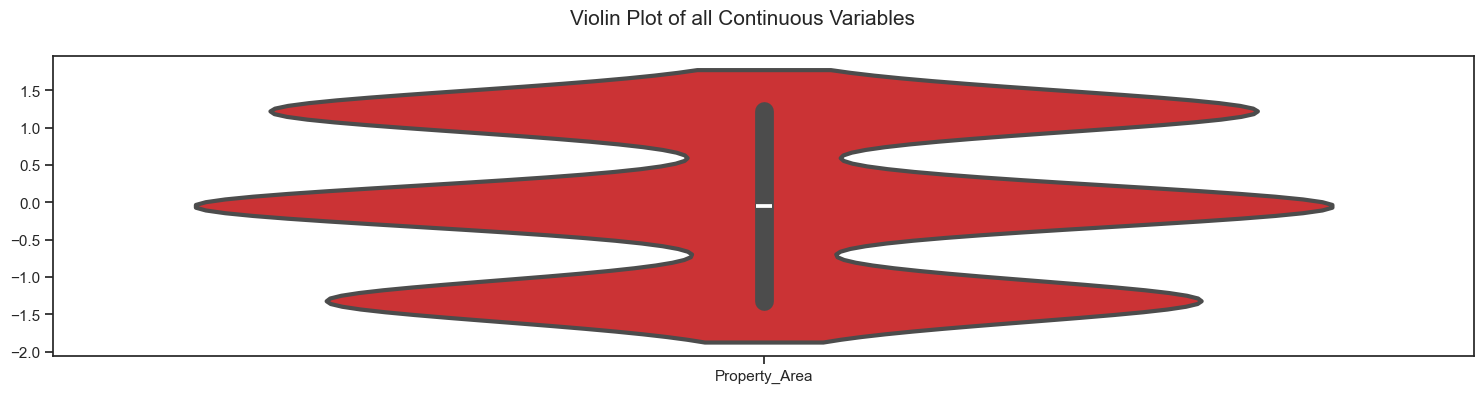

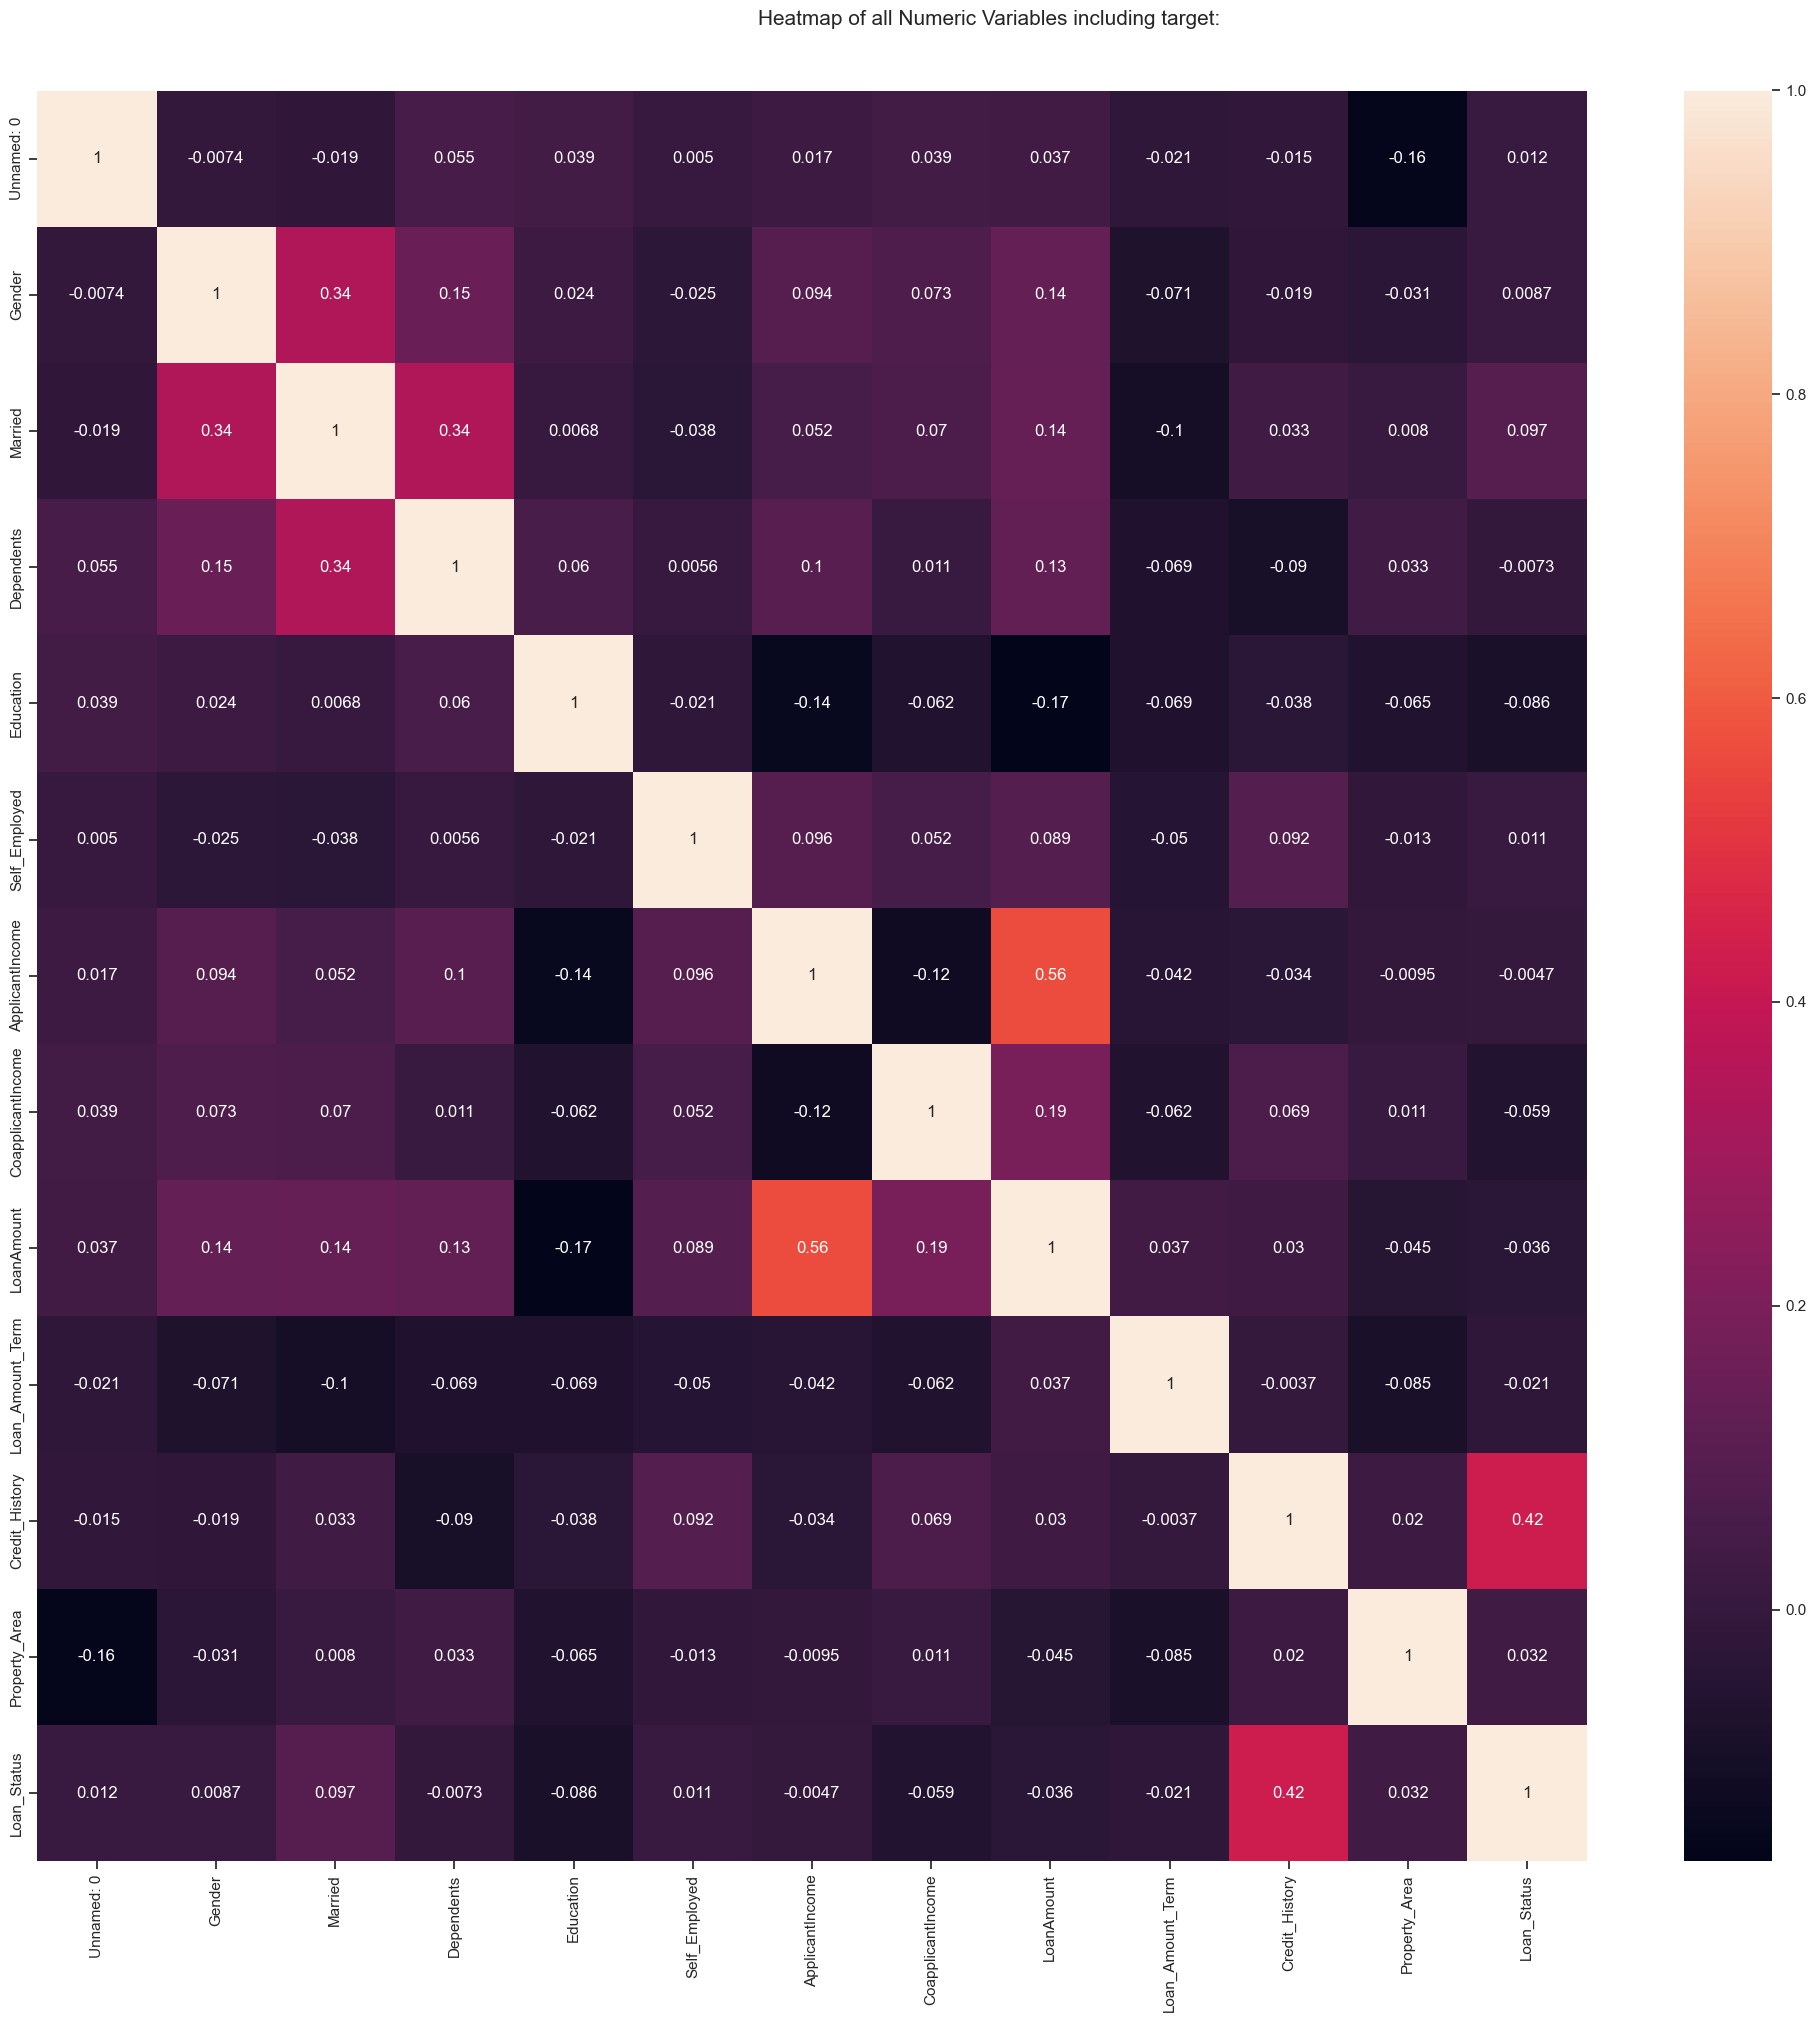

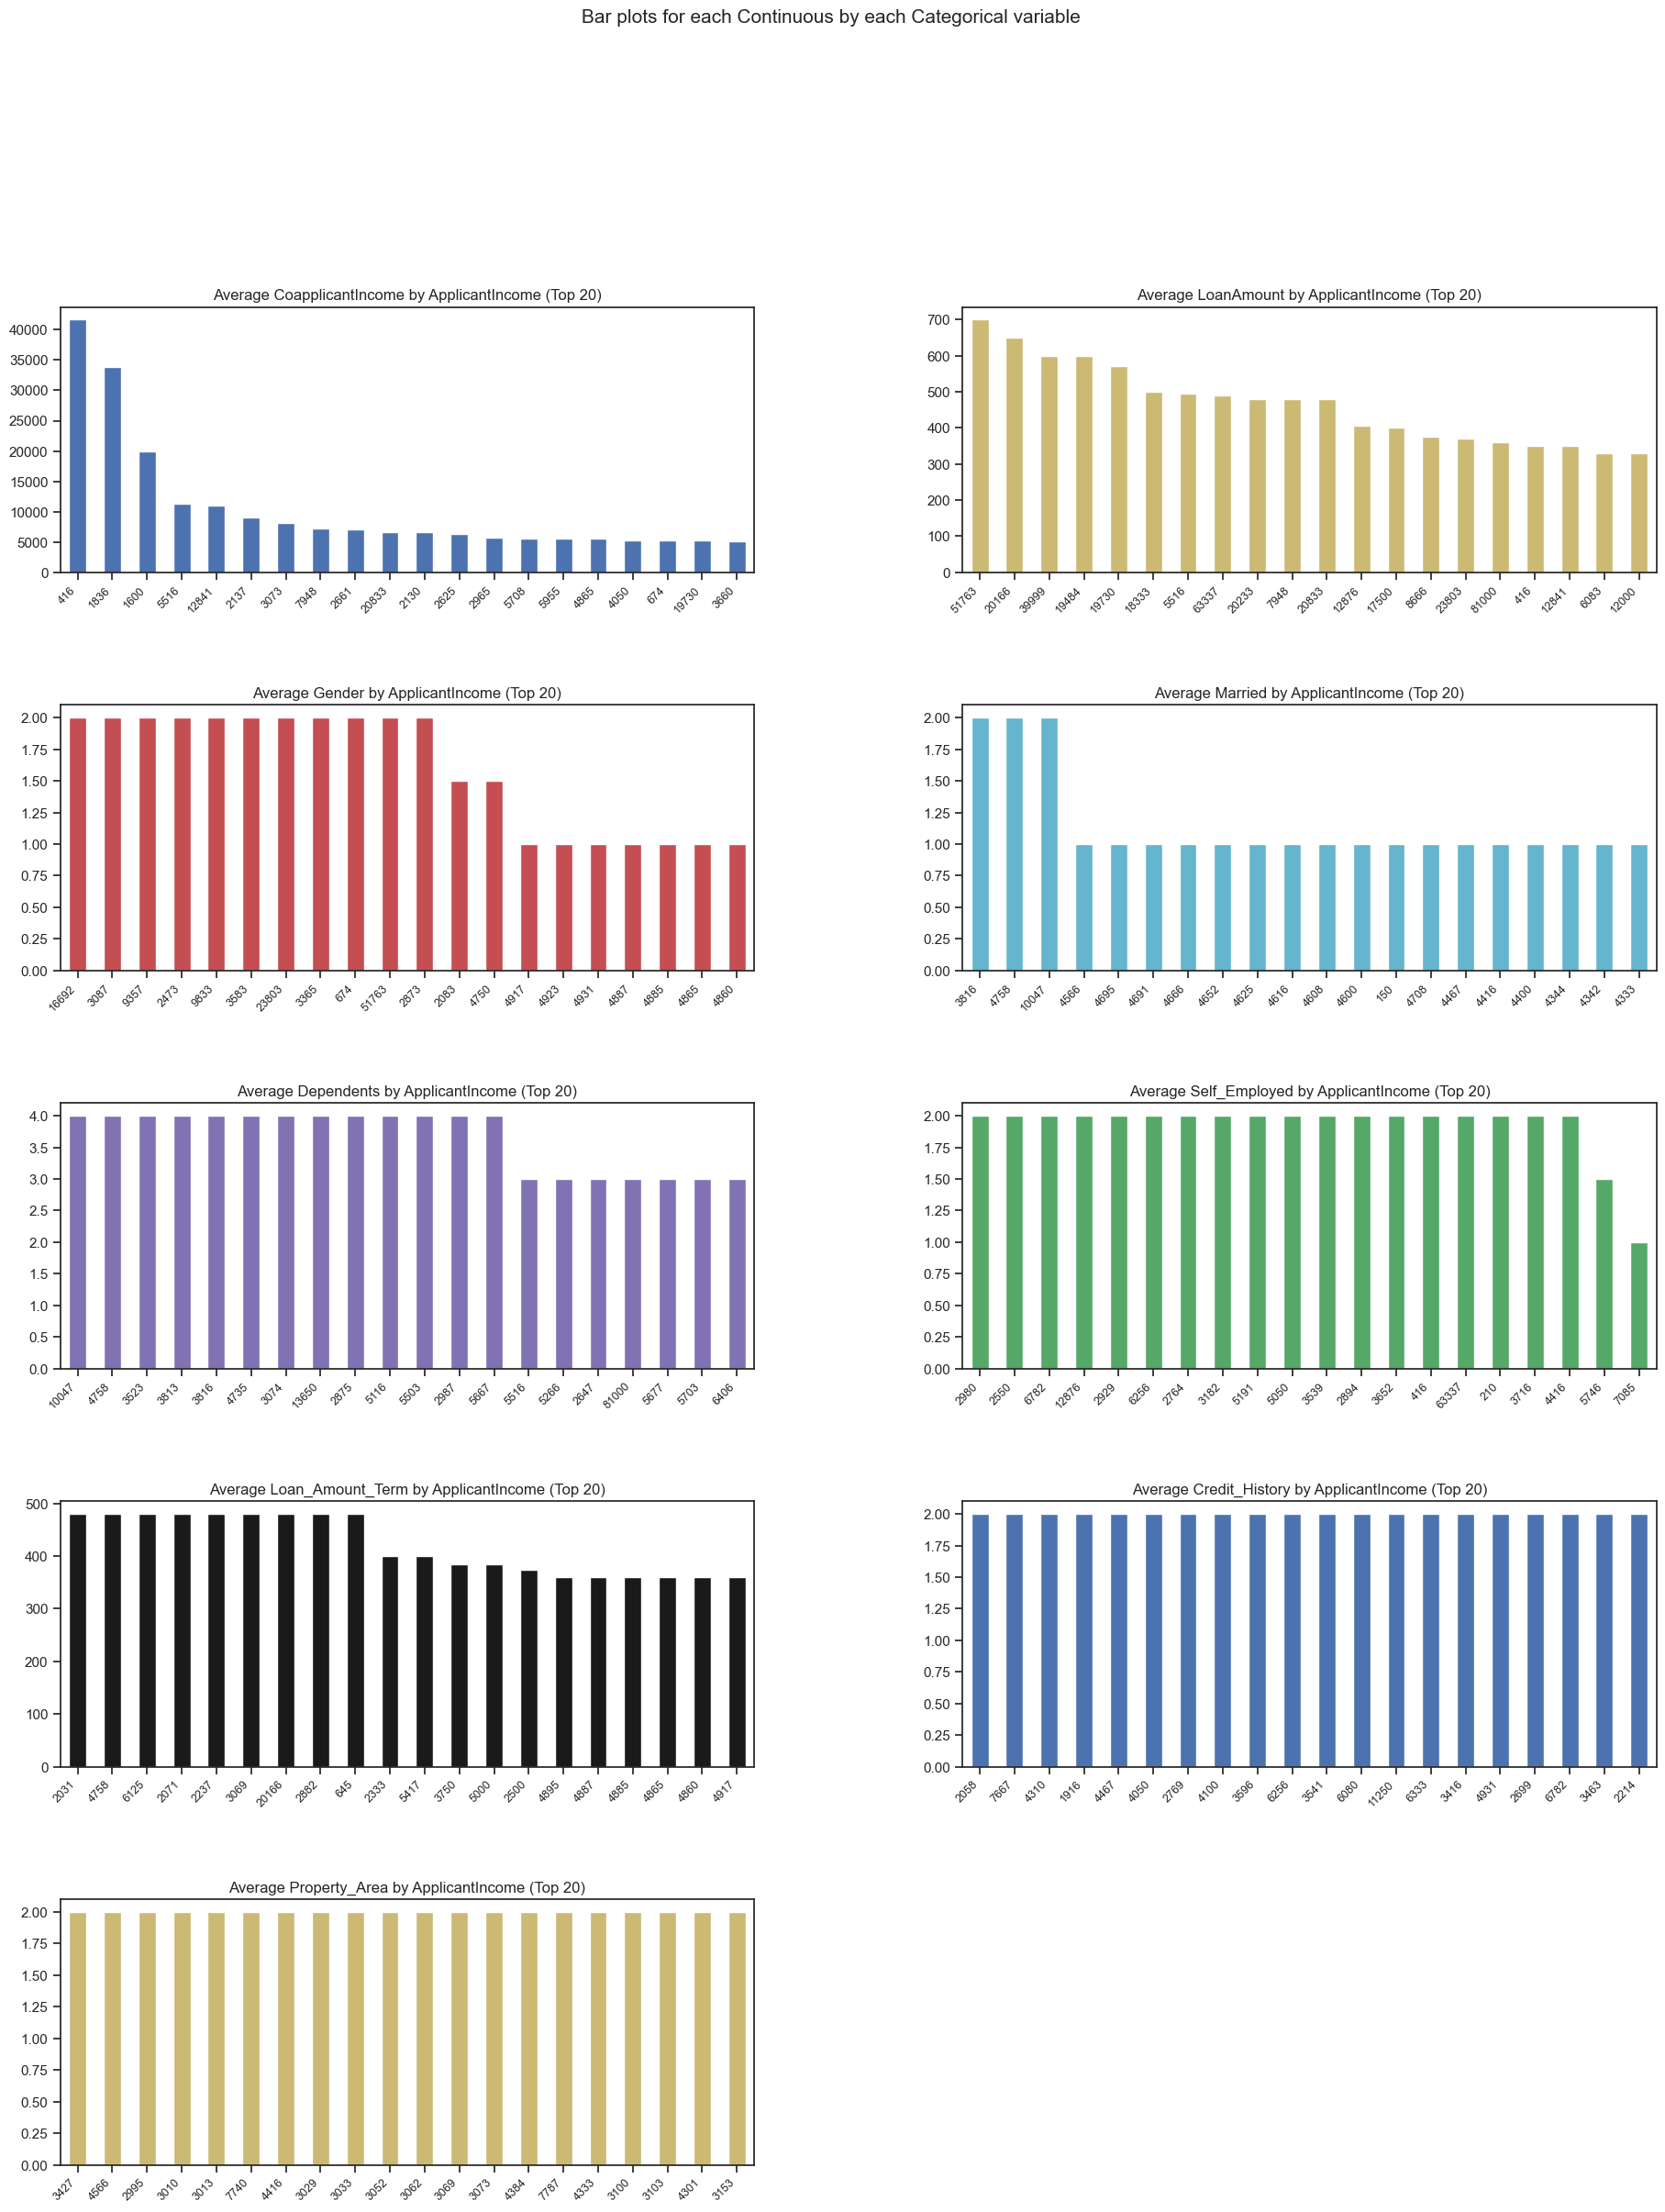

All Plots done
Time to run AutoViz = 8 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


Unnamed: 0  Gender  Married  Dependents  Education  Self_Employed  \
0          0       1.0     0.0        0.0        0.0          0.0        
1          1       1.0     1.0        1.0        0.0          0.0        
2          2       1.0     1.0        0.0        0.0          1.0        
3          3       1.0     1.0        0.0        1.0          0.0        
4          4       1.0     0.0        0.0        0.0          0.0        
..          ...     ...      ...         ...        ...            ...   
609      609       0.0     0.0        0.0        0.0          0.0        
610      610       1.0     1.0        3.0        0.0          0.0        
611      611       1.0     1.0        1.0        0.0          0.0        
612      612       1.0     1.0        2.0        0.0          0.0        
613      613       0.0     0.0        0.0        0.0          1.0        

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         5849                0.0           128.0          360.0        
1         4583             1508.0           128.0          360.0        
2         3000                0.0            66.0          360.0        
3         2583             2358.0           120.0          360.0        
4         6000                0.0           141.0          360.0        
..               ...                ...         ...               ...   
609       2900                0.0            71.0          360.0        
610       4106                0.0            40.0          180.0        
611       8072              240.0           253.0          360.0        
612       7583                0.0           187.0          360.0        
613       4583                0.0           133.0          360.0        

     Credit_History  Property_Area  Loan_Status  
0          1.0            2.0           1.0      
1          1.0            0.0           0.0      
2          1.0            2.0           1.0      
3          1.0            2.0           1.0      
4          1.0            2.0           1.0      
..              ...            ...          ...  
609        1.0            0.0           1.0      
610        1.0            0.0           1.0      
611        1.0            2.0           1.0      
612        1.0            2.0           1.0      
613        0.0            1.0           0.0      

[614 rows x 13 columns]

In [40]:
AV.AutoViz(df)

In [41]:
def outliers_df(df, cols):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in cols:  # Ensure processing numeric columns only
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]

In [42]:
outliers_cols = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term']

In [52]:
def outliers(df, cols):
    label_out_df = df.copy()
    for col in label_out_df:
        if col in cols:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            label_out_df[col] = np.where(label_out_df[col] > upper_limit,'Outlier',np.where(label_out_df[col] < lower_limit,'Outlier',label_out_df[col]))
    return label_out_df

In [54]:
new_df_outliers = outliers(df, outliers_cols)
new_df_outliers.head(10)

Unnamed: 0  Gender  Married  Dependents  Education  Self_Employed  \
0       0        1.0     0.0        0.0        0.0          0.0        
1       1        1.0     1.0        1.0        0.0          0.0        
2       2        1.0     1.0        0.0        0.0          1.0        
3       3        1.0     1.0        0.0        1.0          0.0        
4       4        1.0     0.0        0.0        0.0          0.0        
5       5        1.0     1.0        2.0        0.0          1.0        
6       6        1.0     1.0        0.0        1.0          0.0        
7       7        1.0     1.0        3.0        0.0          0.0        
8       8        1.0     1.0        2.0        0.0          0.0        
9       9        1.0     1.0        1.0        0.0          0.0        

  ApplicantIncome CoapplicantIncome LoanAmount Loan_Amount_Term  \
0         5849              0.0         128.0        360.0        
1         4583           1508.0         128.0        360.0        
2         3000              0.0       Outlier        360.0        
3         2583           2358.0         120.0        360.0        
4         6000              0.0         141.0        360.0        
5         5417          Outlier       Outlier        360.0        
6         2333           1516.0          95.0        360.0        
7         3036           2504.0         158.0        360.0        
8         4006           1526.0         168.0        360.0        
9      Outlier          Outlier       Outlier        360.0        

   Credit_History  Property_Area  Loan_Status  
0        1.0            2.0           1.0      
1        1.0            0.0           0.0      
2        1.0            2.0           1.0      
3        1.0            2.0           1.0      
4        1.0            2.0           1.0      
5        1.0            2.0           1.0      
6        1.0            2.0           1.0      
7        0.0            1.0           0.0      
8        1.0            2.0           1.0      
9        1.0            1.0           0.0

In [56]:
def cocor(x1,y1, x2,y2):
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')
    n1 = len(x1)
    n2 = len(x2)
    xy_z = 0.5 * np.log((1 + xy1)/(1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2)/(1 - xy2))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [58]:
from scipy.stats import norm
from scipy.stats import ks_2samp

c=df
names=outliers_cols
#Creating df that reflects the correlation change
out_df= pd.DataFrame(columns=['feature','outliers_cnt','distribution_changed','correlation_changed'])

In [60]:
df_outliers = new_df_outliers.isin(['Outlier']) 
df_outliers = df_outliers.astype('int')
df_outliers

Unnamed: 0  Gender  Married  Dependents  Education  Self_Employed  \
0         0         0       0          0          0            0         
1         0         0       0          0          0            0         
2         0         0       0          0          0            0         
3         0         0       0          0          0            0         
4         0         0       0          0          0            0         
..          ...     ...      ...         ...        ...            ...   
609       0         0       0          0          0            0         
610       0         0       0          0          0            0         
611       0         0       0          0          0            0         
612       0         0       0          0          0            0         
613       0         0       0          0          0            0         

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0           0                 0               0              0          
1           0                 0               0              0          
2           0                 0               1              0          
3           0                 0               0              0          
4           0                 0               0              0          
..               ...                ...         ...               ...   
609         0                 0               0              0          
610         0                 0               1              1          
611         1                 0               1              0          
612         1                 0               0              0          
613         0                 0               0              0          

     Credit_History  Property_Area  Loan_Status  
0           0              0             0       
1           0              0             0       
2           0              0             0       
3           0              0             0       
4           0              0             0       
..              ...            ...          ...  
609         0              0             0       
610         0              0             0       
611         0              0             0       
612         0              0             0       
613         0              0             0       

[614 rows x 13 columns]

In [64]:
no_outliers = df.copy()
out_df = pd.DataFrame()
np.seterr(divide='ignore', invalid='ignore')

for i in outliers_cols:
    # df with outliers
    out = df[i]
    # df without outliers
    non = df[i].loc[df_outliers[i] == 0]

    # label with outliers
    status_out = df['Loan_Status']
    # label without outliers
    status_non = df['Loan_Status'].loc[df_outliers[i] == 0]
    
    # correlation p-value
    p, pvalue = cocor(out, status_out, non, status_non)
    cor_change = np.where(pvalue < 0.05, '+', '-')
    
    # outliers count
    mv = df_outliers[i].sum()
    
    # outliers percentage
    outliers_percentage = (mv / len(df)) * 100
    
    # ks p-value
    pval = ks_2samp(out, non)[1]
    dist_change = np.where(pval < 0.05, '+', '-')
    
    new_row = pd.DataFrame({
        'feature': [i],
        'outliers_cnt': [mv],
        'outliers_percentage': [outliers_percentage],
        'distribution_changed': [dist_change],
        'correlation_changed': [cor_change]
    })
    
    out_df = pd.concat([out_df, new_row], ignore_index=True)

out_df.head()


feature        outliers_cnt  outliers_percentage distribution_changed  \
0         LoanAmount       133           21.661238                +            
1    ApplicantIncome       107           17.426710                +            
2  CoapplicantIncome        74           12.052117                +            
3   Loan_Amount_Term        90           14.657980                +            

  correlation_changed  
0           -          
1           -          
2           -          
3           -

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_with_boundaries(df, column):
    mean_val = df[column].mean()
    std_val = df[column].std()
    lower_sigma = max(0, mean_val - 3 * std_val)
    upper_sigma = mean_val + 3 * std_val

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = max(0, Q1 - 1.5 * IQR)
    upper_iqr = Q3 + 1.5 * IQR

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])

    plt.axvline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val}')
    plt.axvline(lower_sigma, color='red', linestyle='--', label=f'Lower 3-Sigma: {lower_sigma}')
    plt.axvline(upper_sigma, color='red', linestyle='--', label=f'Upper 3-Sigma: {upper_sigma}')
    plt.axvline(lower_iqr, color='blue', linestyle='--', label=f'Lower IQR: {lower_iqr}')
    plt.axvline(upper_iqr, color='blue', linestyle='--', label=f'Upper IQR: {upper_iqr}')

    plt.legend()
    plt.title(f'{column} with IQR and 3-Sigma Boundaries')
    plt.xlabel(column)
    plt.show()


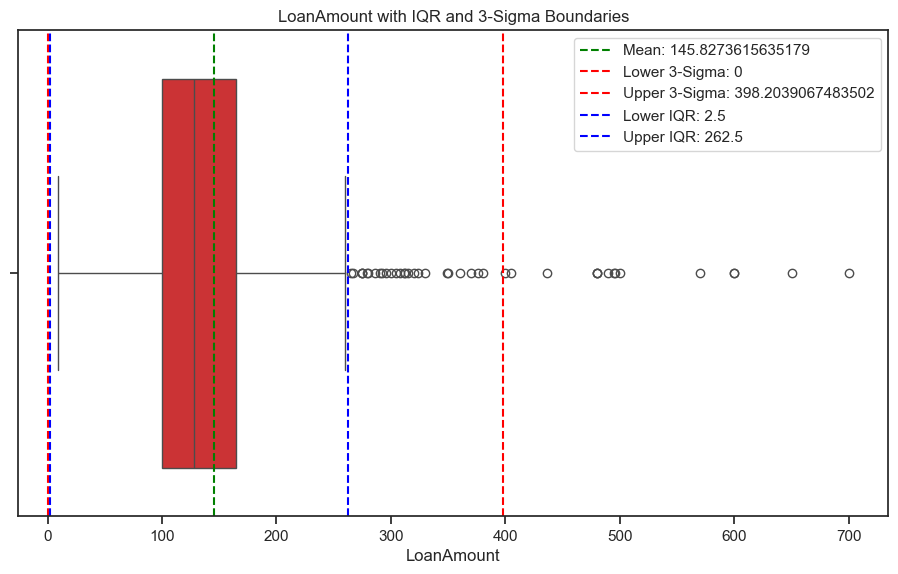

In [72]:
plot_with_boundaries(df, 'LoanAmount')

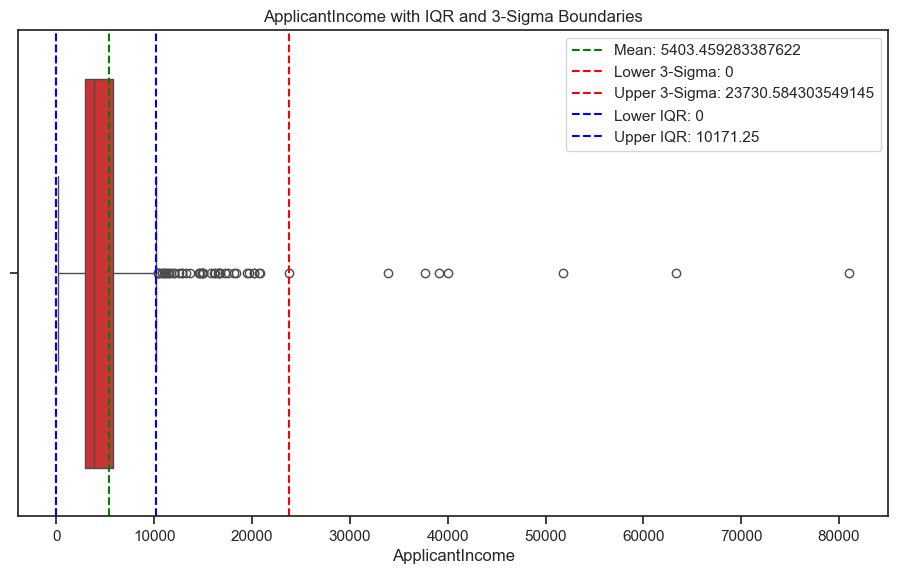

In [74]:
plot_with_boundaries(df, 'ApplicantIncome')

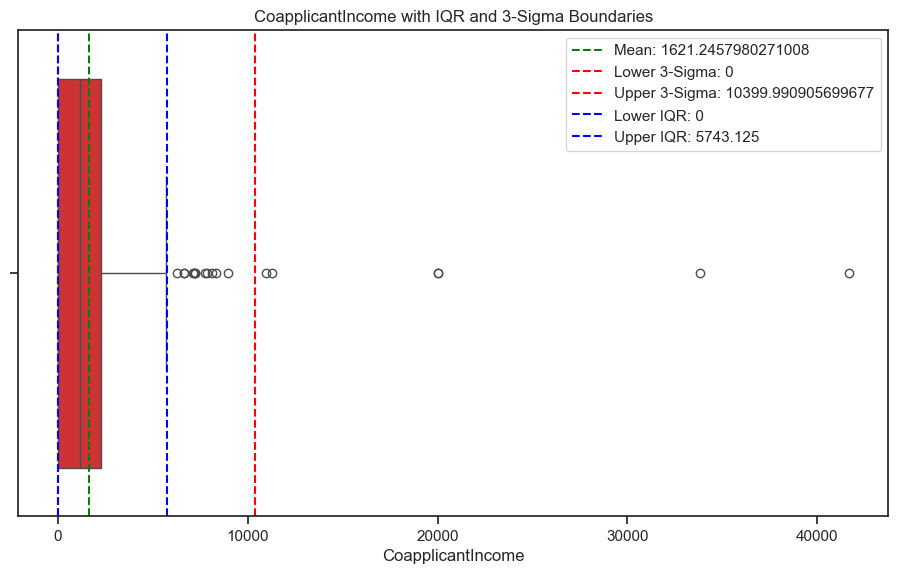

In [76]:
plot_with_boundaries(df, 'CoapplicantIncome')

Although removing them wouldn't impact the correlations, outliers were retained in the continuous variables—LoanAmount, ApplicantIncome, and CoapplicantIncome—because of their substantial presence. This indicates that these values are not just random anomalies, but are crucial elements of the dataset, vital for making accurate predictions.

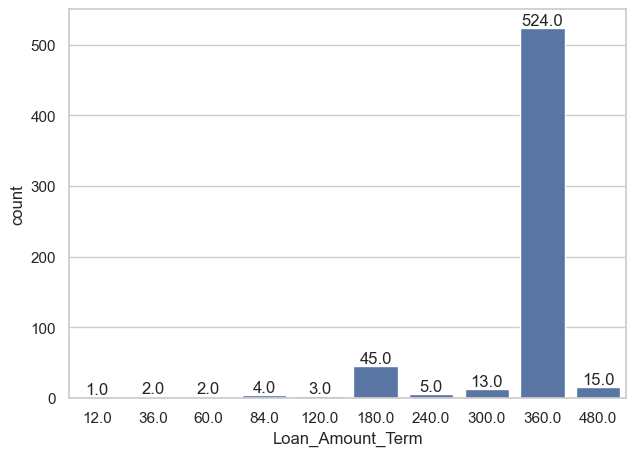

In [86]:
plot_countplot_with_annotations(df, df['Loan_Amount_Term'])

The Loan_Amount_Term column is more categorical than continuous, given that it contains only 10 unique values. The distribution is uneven, with the majority of entries (524 out of 614) falling within the 360-month category. Therefore, it would be logical to simplify this column by reducing the categories to just two: 360+ months and others.

In [90]:
df['Loan_Amount_Term_Bin'] = df['Loan_Amount_Term'].apply(lambda x: 1 if x >= 360 else 0)
df= df.drop(columns=['Loan_Amount_Term'])

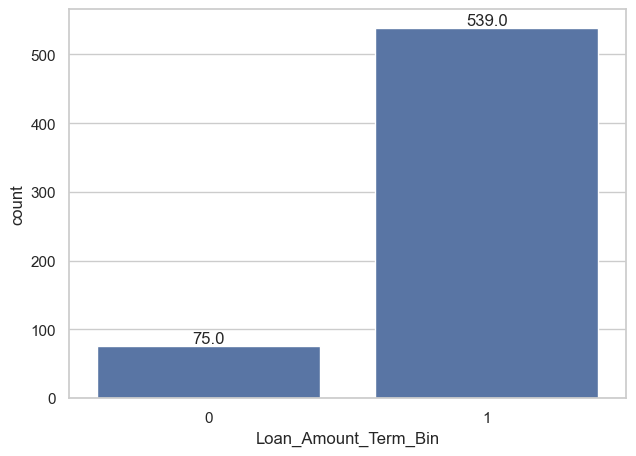

In [94]:
plot_countplot_with_annotations(df, df['Loan_Amount_Term_Bin'])

Finalized data frame info:

In [96]:
# Field types and basic info

def summarize_dataframe(df):
    summary = {
        'Series': [],
        'Type': [],
        'Unique Values': [],
        'Min Value': [],
        'Max Value': [],
        'Mean Value': [],
        'Mode Value': []
    }

    for column in df.columns:
        summary['Series'].append(column)
        summary['Type'].append(df[column].dtype)
        summary['Unique Values'].append(df[column].nunique())
        summary['Min Value'].append(df[column].min() if pd.api.types.is_numeric_dtype(df[column]) else None)
        summary['Max Value'].append(df[column].max() if pd.api.types.is_numeric_dtype(df[column]) else None)
        summary['Mean Value'].append(df[column].mean() if pd.api.types.is_numeric_dtype(df[column]) else None)
        summary['Mode Value'].append(df[column].mode()[0] if not df[column].mode().empty else None)

    return pd.DataFrame(summary)

In [98]:
summarize_dataframe(df)

Series          Type    Unique Values  Min Value  Max Value  \
0             Unnamed: 0    int64       614           0.0       613.0    
1                 Gender  float64         3           0.0         2.0    
2                Married  float64         3           0.0         2.0    
3             Dependents  float64         5           0.0         4.0    
4              Education  float64         2           0.0         1.0    
5          Self_Employed  float64         3           0.0         2.0    
6        ApplicantIncome    int64       505         150.0     81000.0    
7      CoapplicantIncome  float64       287           0.0     41667.0    
8             LoanAmount  float64       203           9.0       700.0    
9         Credit_History  float64         3           0.0         2.0    
10         Property_Area  float64         3           0.0         2.0    
11           Loan_Status  float64         2           0.0         1.0    
12  Loan_Amount_Term_Bin    int64         2           0.0         1.0    

    Mean Value   Mode Value  
0    306.500000       0.0    
1      0.838762       1.0    
2      0.657980       1.0    
3      0.842020       0.0    
4      0.218241       0.0    
5      0.237785       0.0    
6   5403.459283    2500.0    
7   1621.245798       0.0    
8    145.827362     128.0    
9      0.936482       1.0    
10     1.037459       1.0    
11     0.687296       1.0    
12     0.877850       1.0

Shape of your Data Set loaded: (614, 13)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  8
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  3
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    13 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['Unnamed: 0']
To fix these data quality issues in the dataset, impor

Number of All Scatter Plots = 36


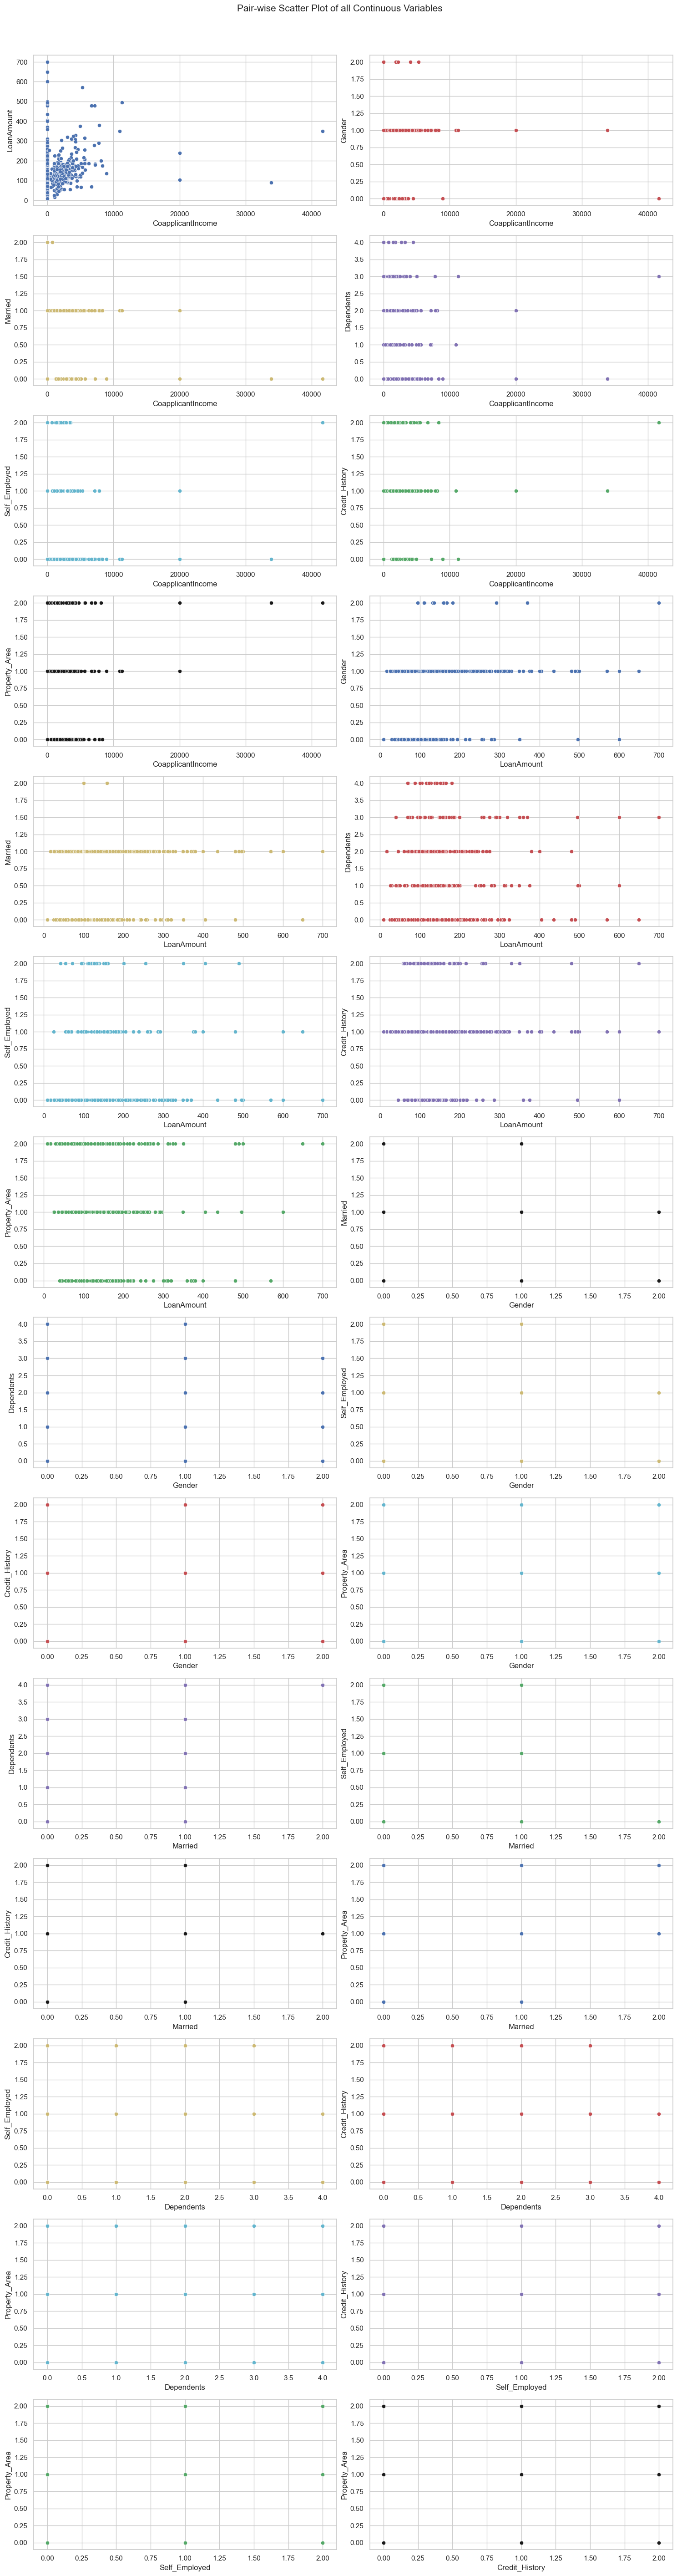

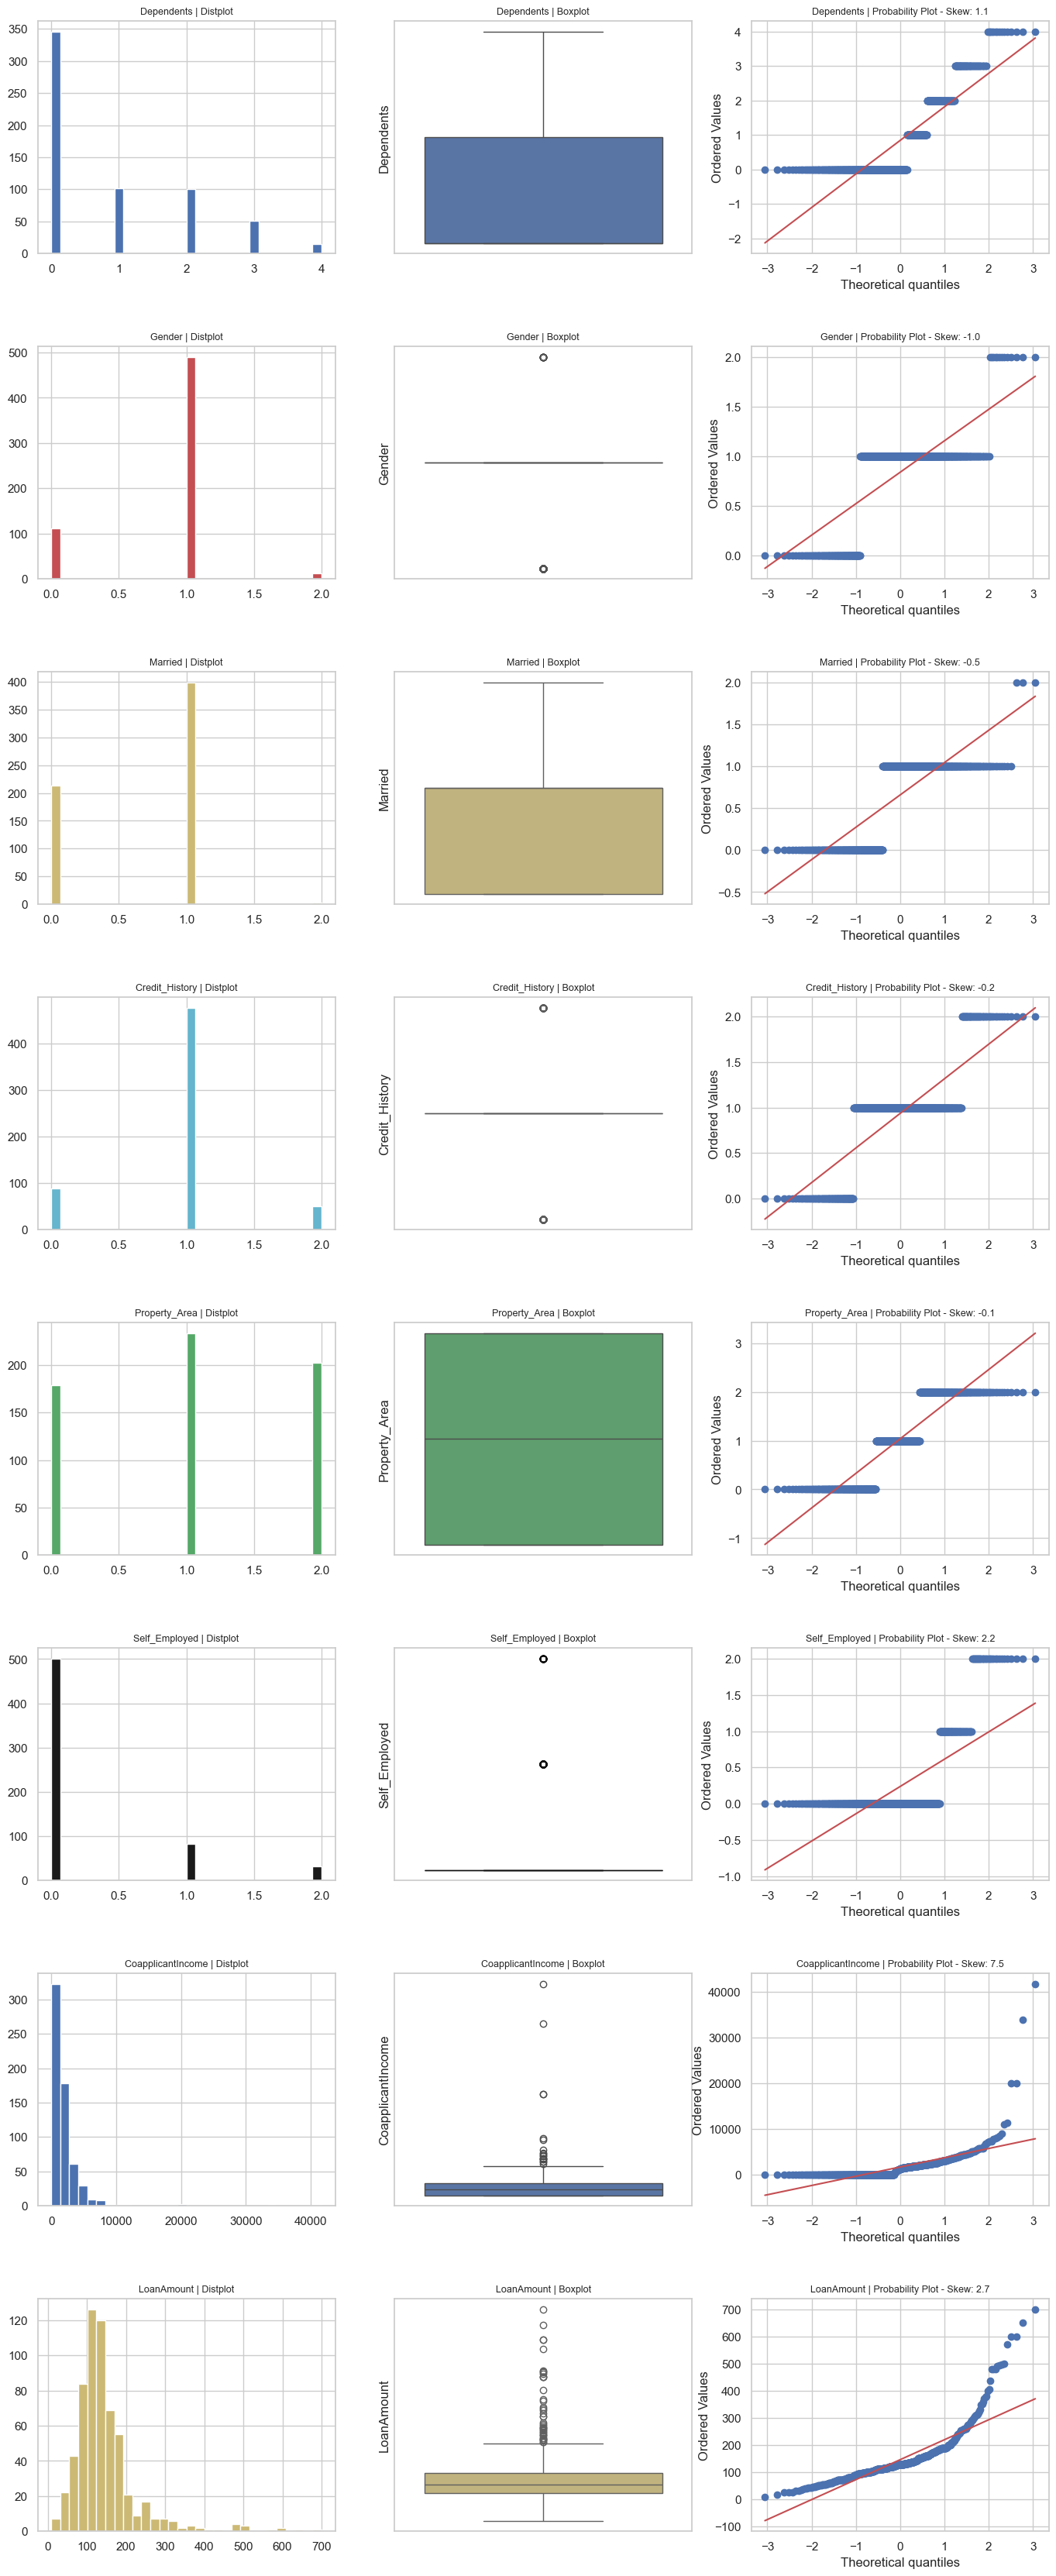

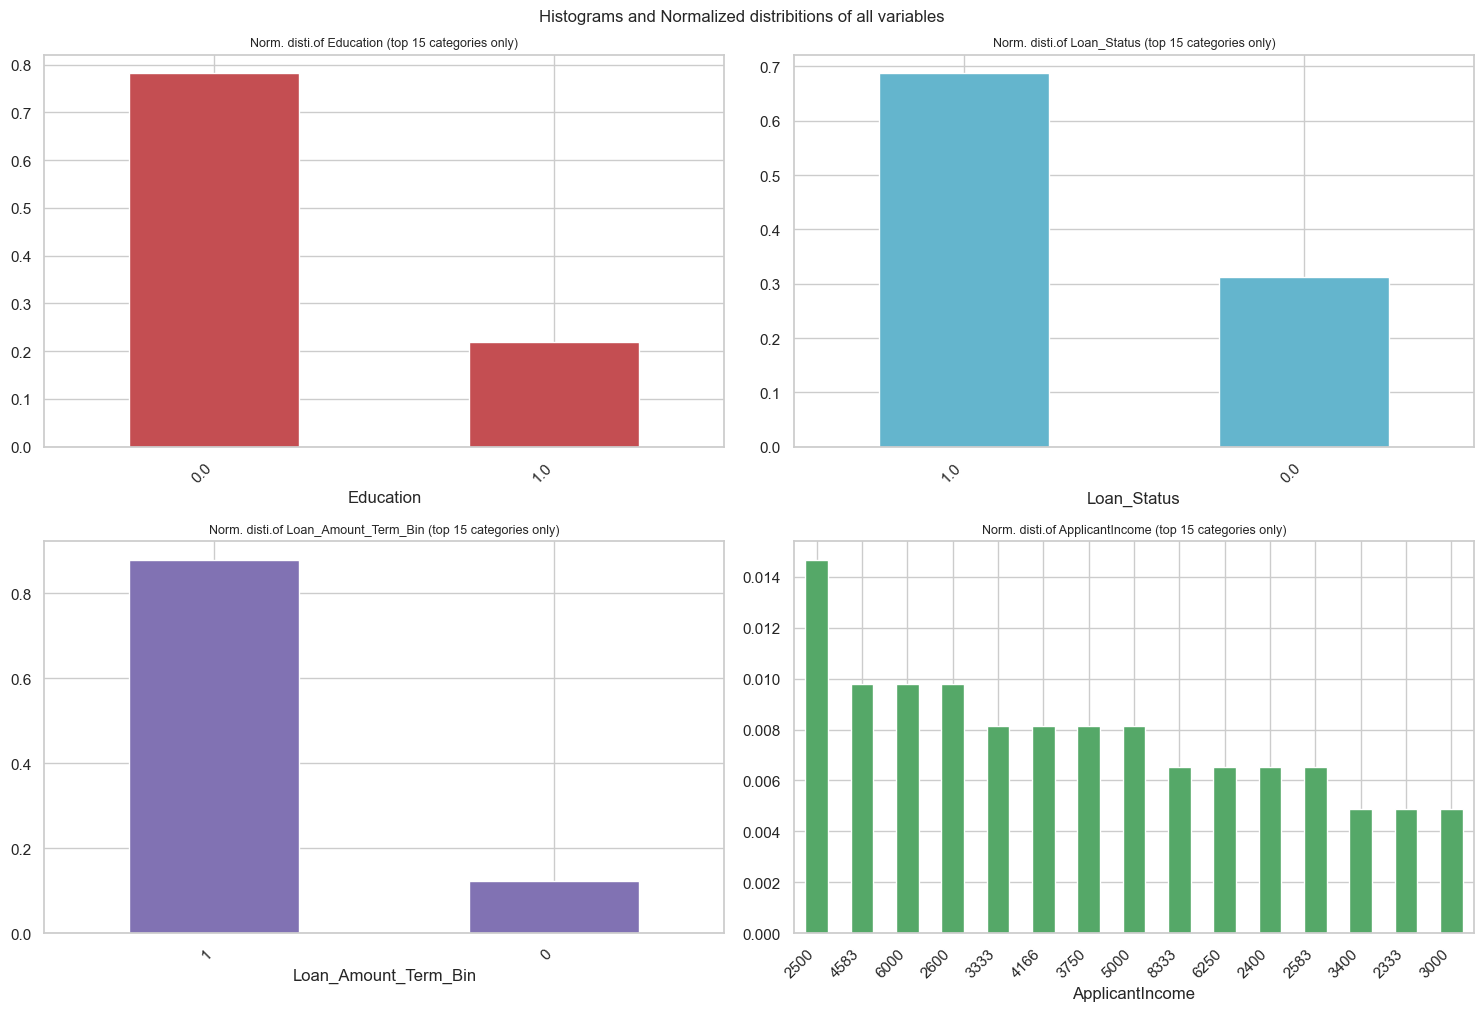

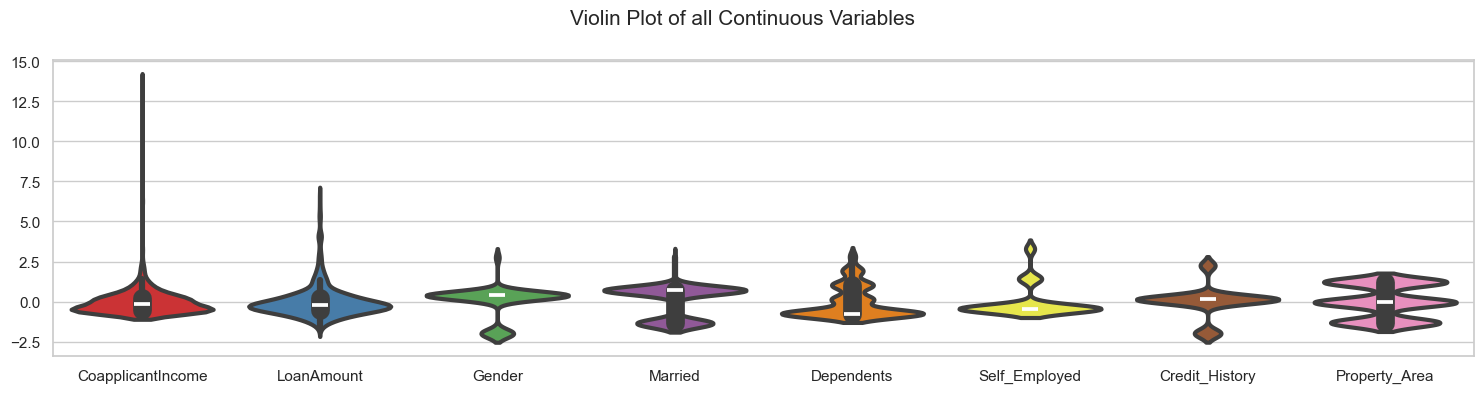

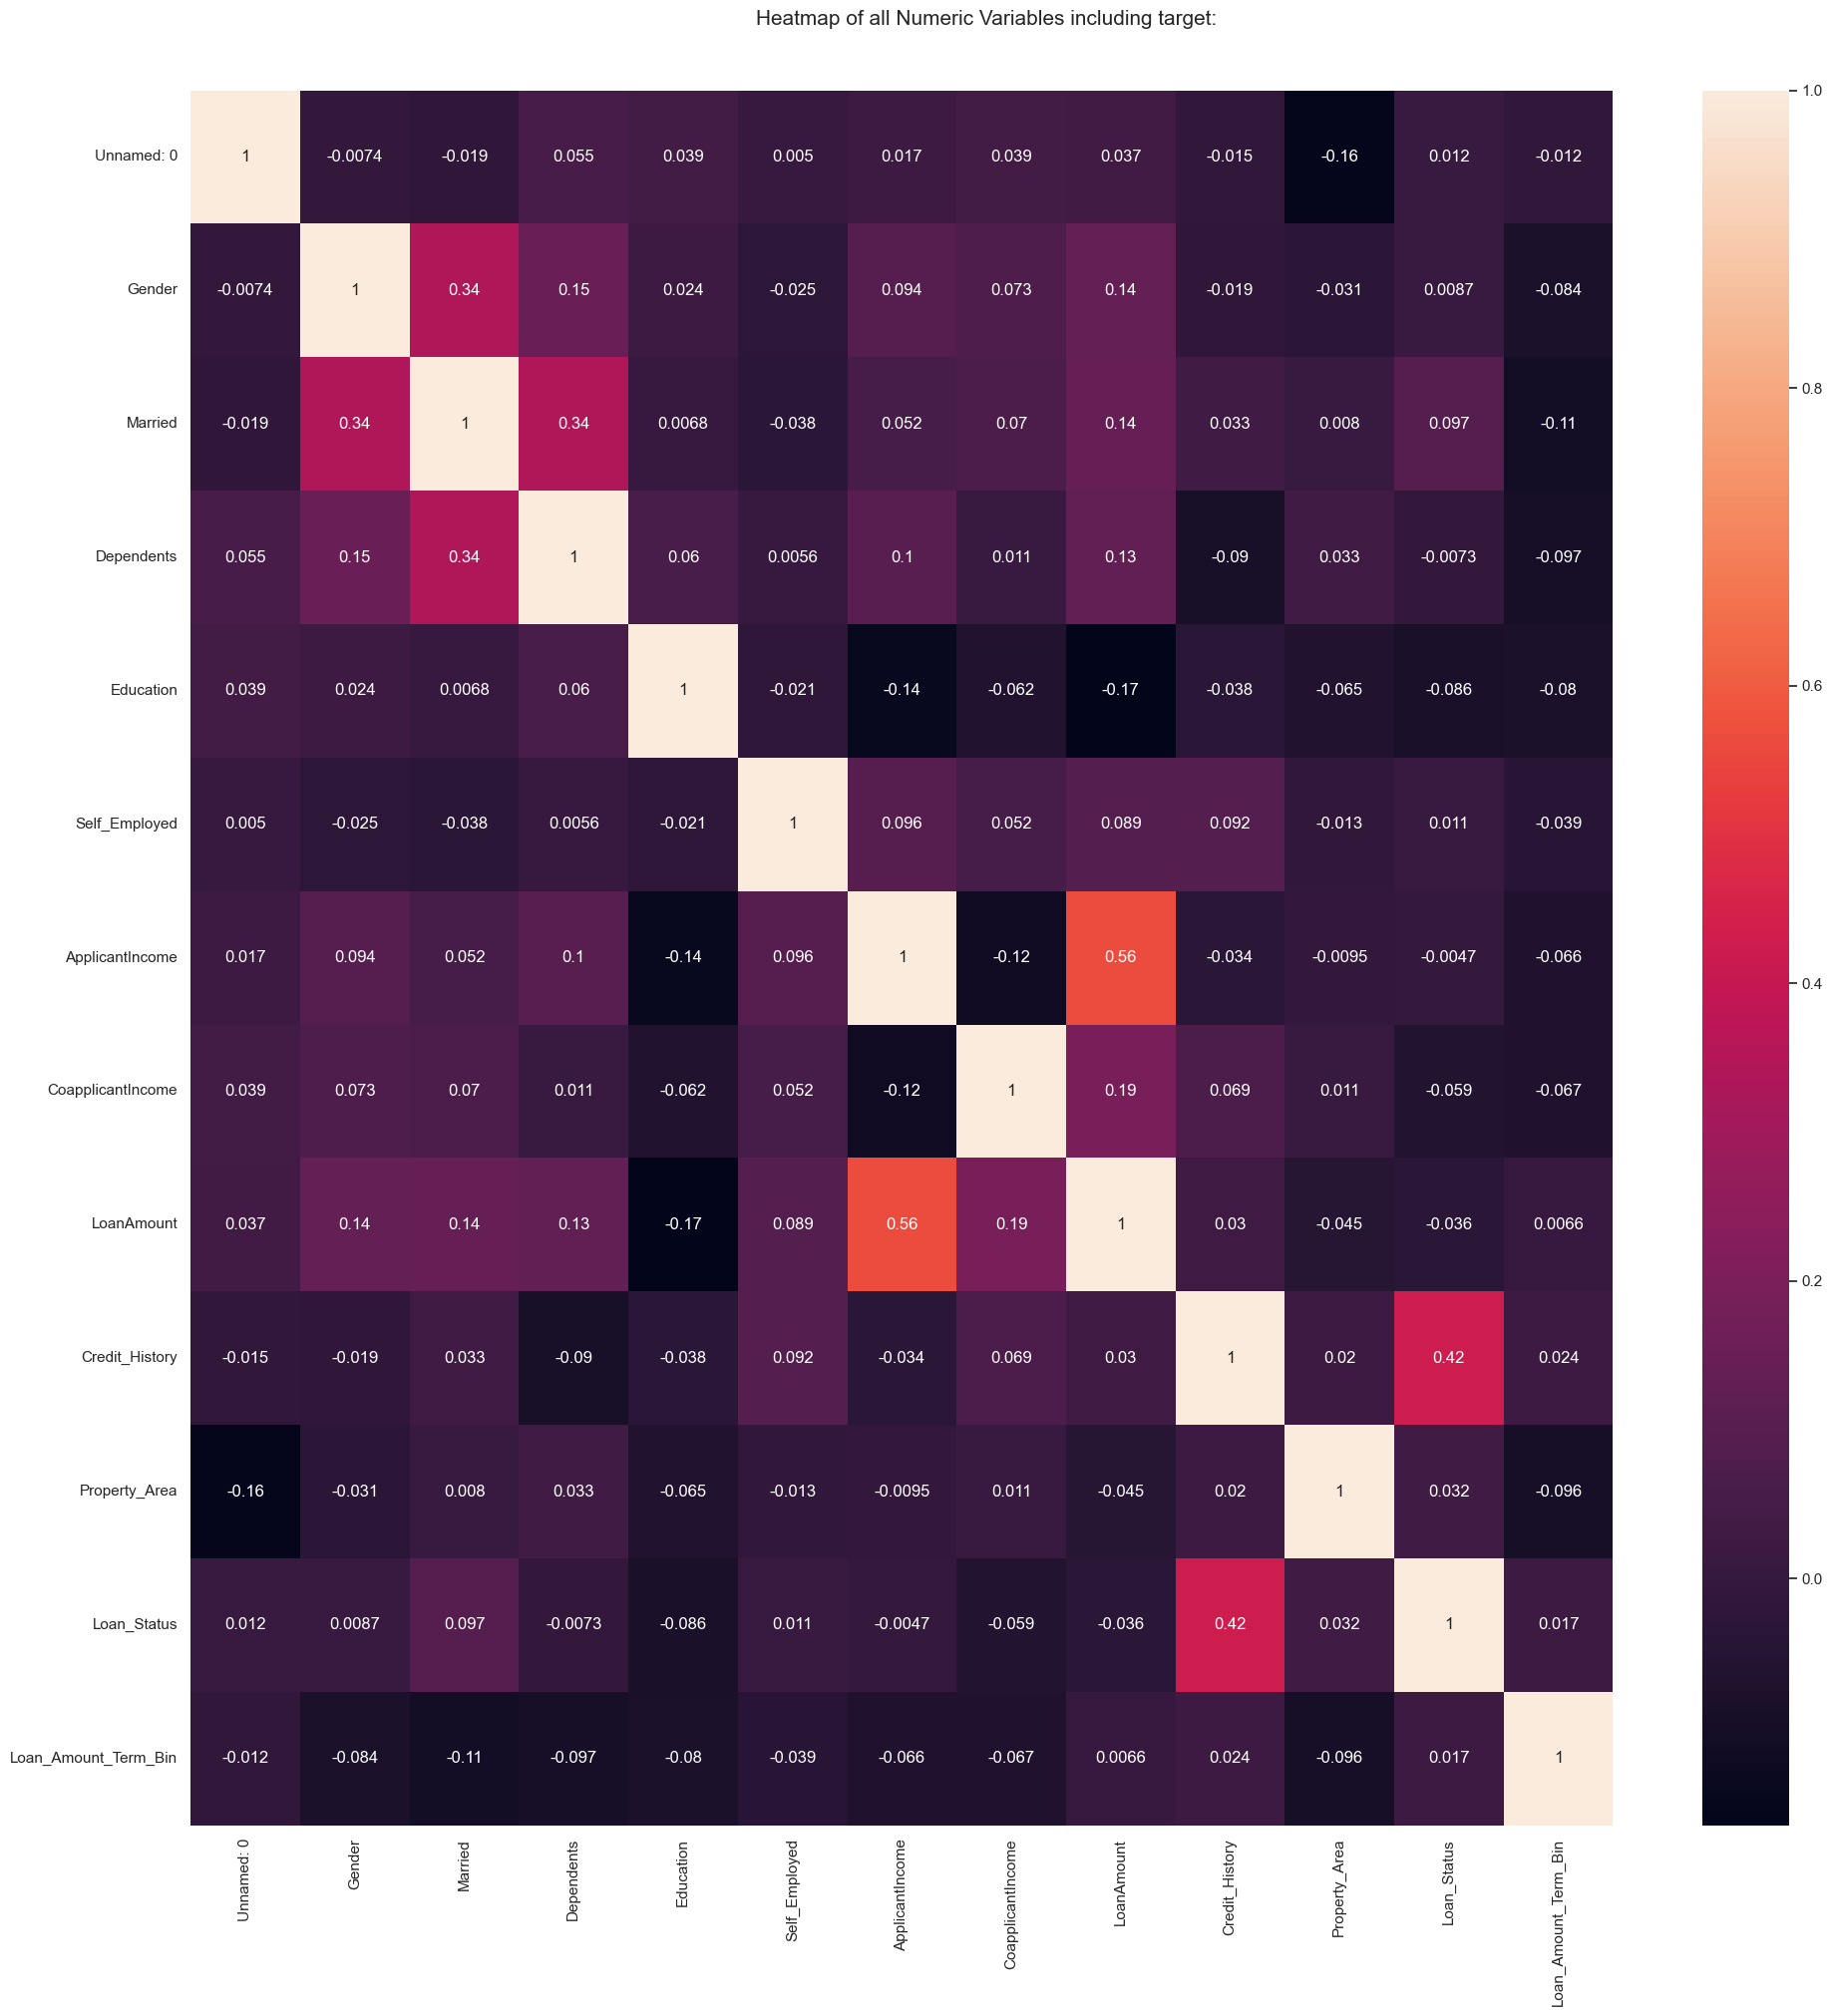

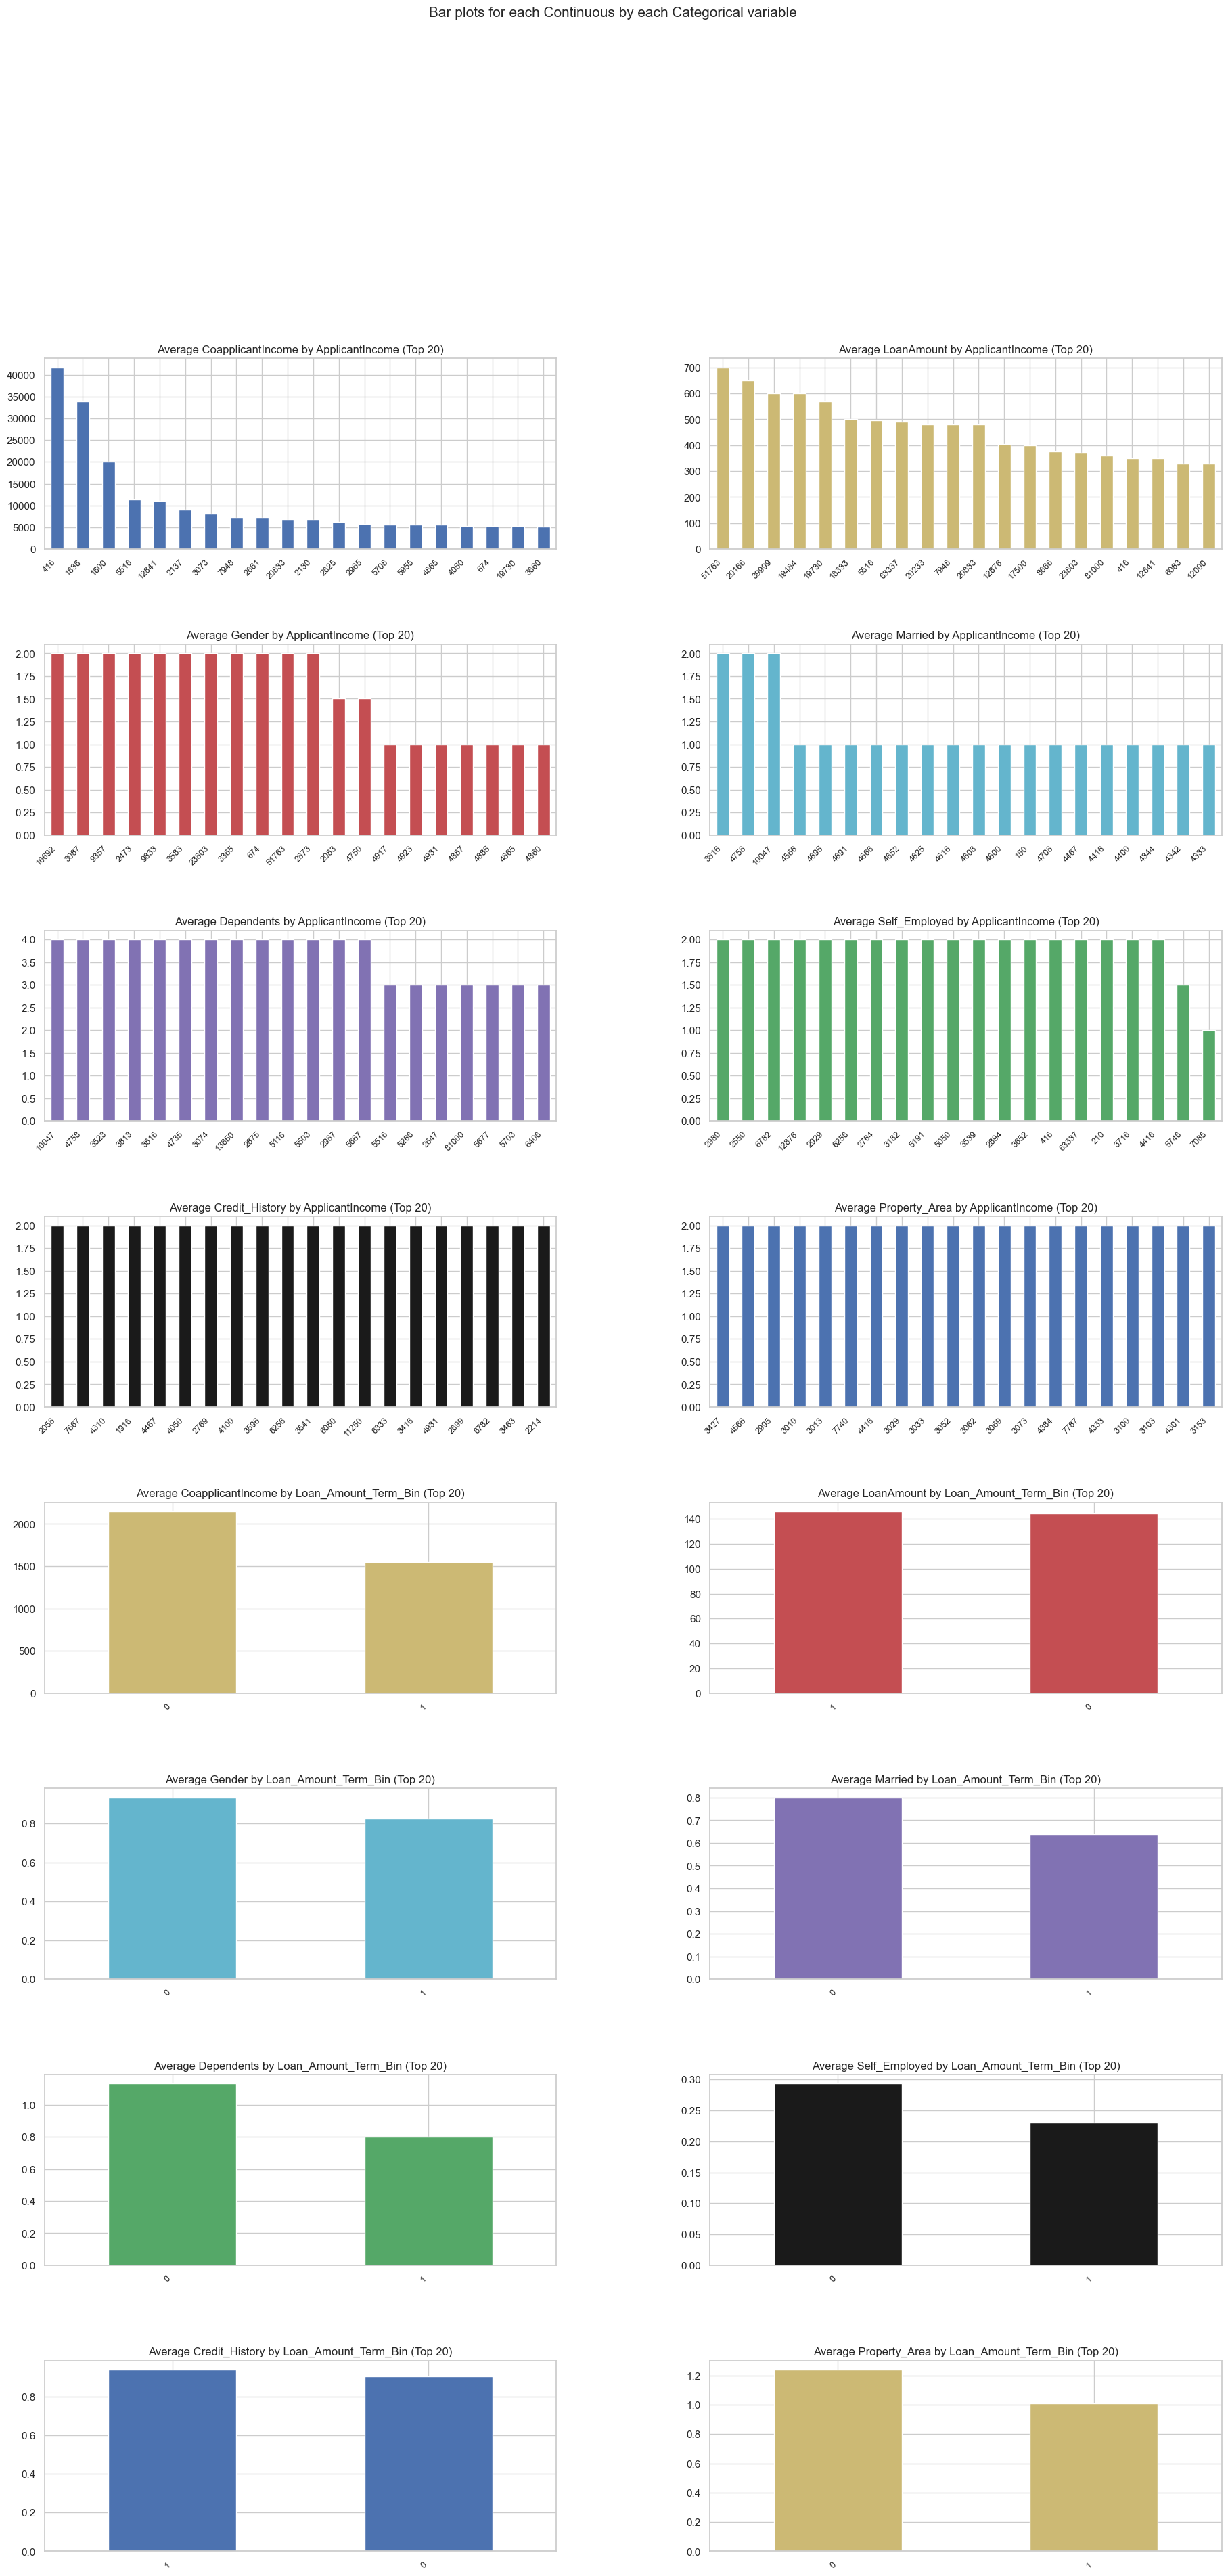

All Plots done
Time to run AutoViz = 10 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


Unnamed: 0  Gender  Married  Dependents  Education  Self_Employed  \
0          0       1.0     0.0        0.0        0.0          0.0        
1          1       1.0     1.0        1.0        0.0          0.0        
2          2       1.0     1.0        0.0        0.0          1.0        
3          3       1.0     1.0        0.0        1.0          0.0        
4          4       1.0     0.0        0.0        0.0          0.0        
..          ...     ...      ...         ...        ...            ...   
609      609       0.0     0.0        0.0        0.0          0.0        
610      610       1.0     1.0        3.0        0.0          0.0        
611      611       1.0     1.0        1.0        0.0          0.0        
612      612       1.0     1.0        2.0        0.0          0.0        
613      613       0.0     0.0        0.0        0.0          1.0        

     ApplicantIncome  CoapplicantIncome  LoanAmount  Credit_History  \
0         5849                0.0           128.0          1.0        
1         4583             1508.0           128.0          1.0        
2         3000                0.0            66.0          1.0        
3         2583             2358.0           120.0          1.0        
4         6000                0.0           141.0          1.0        
..               ...                ...         ...             ...   
609       2900                0.0            71.0          1.0        
610       4106                0.0            40.0          1.0        
611       8072              240.0           253.0          1.0        
612       7583                0.0           187.0          1.0        
613       4583                0.0           133.0          0.0        

     Property_Area  Loan_Status  Loan_Amount_Term_Bin  
0         2.0           1.0                1           
1         0.0           0.0                1           
2         2.0           1.0                1           
3         2.0           1.0                1           
4         2.0           1.0                1           
..             ...          ...                   ...  
609       0.0           1.0                1           
610       0.0           1.0                0           
611       2.0           1.0                1           
612       2.0           1.0                1           
613       1.0           0.0                1           

[614 rows x 13 columns]

In [100]:
AV.AutoViz(df)

In [102]:
df.to_csv("loans_clean.csv")